In [2]:
# Turn off code warnings (this is not recommended for routine use)
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import scipy.stats as st
import statsmodels as sm
import matplotlib
import pandas as pd
import io
import requests
import seaborn as sns
from sklearn.metrics import classification_report

%matplotlib inline

## Загрузим данные.

In [419]:
aso = pd.read_csv('data\\aac_shelter_outcomes.csv')

In [8]:
aso.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [12]:
aso.sample(5)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
40325,5 months,A707334,Dog,Australian Kelpie Mix,Black,2015-02-17T00:00:00,2015-07-23T17:46:00,2015-07-23T17:46:00,Babydog,NaN,Adoption,Spayed Female
3472,12 years,A681993,Dog,Rat Terrier,Tricolor,2002-06-22T00:00:00,2014-07-26T12:50:00,2014-07-26T12:50:00,Blue,NaN,Adoption,Neutered Male
61556,8 years,A721767,Dog,Chihuahua Shorthair/Rat Terrier,Black,2009-03-04T00:00:00,2017-06-05T19:29:00,2017-06-05T19:29:00,*Spratt,Foster,Adoption,Neutered Male
27898,1 year,A731916,Dog,Lhasa Apso Mix,White,2015-07-29T00:00:00,2017-03-03T18:31:00,2017-03-03T18:31:00,Mimmie,NaN,Return to Owner,Intact Female
30096,5 years,A702168,Dog,Miniature Pinscher Mix,Chocolate/Tan,2010-05-10T00:00:00,2015-05-11T18:45:00,2015-05-11T18:45:00,Timmy,NaN,Return to Owner,Neutered Male


In [10]:
aso.shape

(78256, 12)

In [13]:
aso.keys()

Index(['age_upon_outcome', 'animal_id', 'animal_type', 'breed', 'color',
       'date_of_birth', 'datetime', 'monthyear', 'name', 'outcome_subtype',
       'outcome_type', 'sex_upon_outcome'],
      dtype='object')

In [14]:
aso.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78256 entries, 0 to 78255
Data columns (total 12 columns):
age_upon_outcome    78248 non-null object
animal_id           78256 non-null object
animal_type         78256 non-null object
breed               78256 non-null object
color               78256 non-null object
date_of_birth       78256 non-null object
datetime            78256 non-null object
monthyear           78256 non-null object
name                54370 non-null object
outcome_subtype     35963 non-null object
outcome_type        78244 non-null object
sex_upon_outcome    78254 non-null object
dtypes: object(12)
memory usage: 7.2+ MB


In [15]:
aso.isnull().sum()

age_upon_outcome        8
animal_id               0
animal_type             0
breed                   0
color                   0
date_of_birth           0
datetime                0
monthyear               0
name                23886
outcome_subtype     42293
outcome_type           12
sex_upon_outcome        2
dtype: int64

In [420]:
import pandas_profiling
aso.profile_report()

Проведём Эксплоративный анализ данных. Сделаем предварительный анализ данных с помощью профайлера (отчёт выдан выше).

Первоначально в наших данных **78256** строк и **12** атрибутов.

In [19]:
aso.shape

(78256, 12)

In [20]:
aso.keys()

Index(['age_upon_outcome', 'animal_id', 'animal_type', 'breed', 'color',
       'date_of_birth', 'datetime', 'monthyear', 'name', 'outcome_subtype',
       'outcome_type', 'sex_upon_outcome'],
      dtype='object')

Сразу интересно посмотреть на предупреждения (возможно особенности, аномалии).  
Предупреждения:

**0. Важно: все первоначальные данные имеют тип признаков (атрибутов) - категориальные (скорее все номинальные).** Как вывод, ящик с усами рисовать не надо!

1. Есть десять строк-**дубликатов** - убедиться и по возможности :) дропнуть.  
2. Наблюдается **высокая кардинальность** (уникальные значения) у семи атрибутов 'animal_id' (70855), 'breed' (2128), 'color' (525), 'date_of_birth' (5869), 'datetime' (64361), 'monthyear' (64361), **'name'** (14574).  
   У шести из этих значений нет отсутствующих (missing) значений. У атрибута **'name'** - много отсутствующих значений, об этом позже (п.4).  
   Но, среди атрибутов с уникальными значениями нет атрибута **'animal_type'**, - у него тоже нет отсутствующих значений. (Показалось, что надо выделить, как особенность: нет отсутствующих значений)  
   Важно: Атрибут 'animal_id' это определённое животное, поэтому у нас и уникальных значений (70855) больше именно у этого атрибута, но всё-таки не столь много, сколько строк в таблице (78256), следовательно могут быть дубликаты по отдельному (но очень важному) столбцу-атрибуту.
   Также важно: Согласно п.1 у нас 10 строк-**дубликатов**, надо посмотреть, что там и как содержимое связано связано со всеми нашими предупреждениями (аномалиями). Например, есть ли в строках-**дубликатах** данные с одинаковыми 'animal_id' или иные особенности. Десять строк, но хотя бы из любопытства узнать, не теряем ли мы что-то важное, а если теряем, то почему это стоит сделать. 
3. Атрибуты 'outcome_type' и 'outcome_subtype' - имеют высокую степень корреляции, возможно второй атрибут 'outcome_subtype' нужно будет дропнуть, если на то будут обоснования. Атрибут 'outcome_type' нужен для анализа,  поскольку внутри находятся метки 'Adoption' и 'Transfer', которые нужно предсказать.  
   Важно (**вопрос?**): атрибуты  'outcome_type' и 'outcome_subtype' имеют разные строковые значения, но если приглядеться, то определённому значению одного атрибута, соответствует определённое значение другого атрибута. Видимо в этом и состоит корреляция подобных атрибутов? Понятно, что один из атрибутов стоит удалить, там содержится дополнительная информация, которая не нужна для анализа, но которую можно всегда увидеть в первоначальном датасете.  
4. Обратим внимание на **все** атрибуты с отсутствующими значениями. Таких атрибутов пять: 'age_upon_outcome' (8), **'name'** (23886), **'outcome_subtype'**(42293), 'outcome_type'(12), 'sex_upon_outcome'(2). Выделены те, у которых очень много отсутствующих значений: потенциальные атрибуты для заполнения или дропа.  
5. Атрибуты 'date_of_birth', 'datetime', 'monthyear' содержат только значения даты-времени.  
   Важно: 'datetime', 'monthyear' имеют одни и те же значения. Возможно атрибут 'monthyear' это копия столбца 'datetime' и его следуте дропнуть.

In [29]:
aso.isnull().sum()==0

age_upon_outcome    False
animal_id            True
animal_type          True
breed                True
color                True
date_of_birth        True
datetime             True
monthyear            True
name                False
outcome_subtype     False
outcome_type        False
sex_upon_outcome    False
dtype: bool

Сделаем копию нашей таблицы, чтобы можно было с ней работать, модифицировать многократно, испытывать код, не изменяя первоначальный датафрейм.

In [182]:
df = aso.copy()

## Пробежимся по атрибутам (пронумеруем от 1 до 12).

  1\. 'age_upon_outcome' ()  
  2\. 'animal_id' ()  
  3\. 'animal_type' ()  
  4\. 'breed' ()  
  5\. 'color' ()  
  6\. 'date_of_birth' ()  
  7\. 'datetime' ()  
  8\. 'monthyear' ()  
  9\. 'name' ()  
10\. 'outcome_subtype' ()  
11\. 'outcome_type' ()  
12\. 'sex_upon_outcome' ()

Ящик с усами для атрибутов (признаков), гистрограммы и подобные представления только для числовых атрибутов, у нас перовначально таких нет.

#### Во время анализа атрибутов (признаков) будем предполагать, что делать с данными (EDA), после сделаем обобщающий вывод и подготовим датасет к задачи классификации.

### Атрибут №1  
'age_upon_outcome' - сколько времени животное провело в приюте

**Сразу стоит отметить, что профайлер показал восемь NaN значений.**

In [100]:
aso['age_upon_outcome'].value_counts(dropna = False)

1 year       14355
2 years      11194
2 months      9213
3 years       5157
3 months      3442
1 month       3344
4 years       2990
5 years       2691
4 months      2425
5 months      1951
6 months      1897
6 years       1810
8 years       1554
7 years       1537
3 weeks       1467
2 weeks       1330
10 months     1204
4 weeks       1194
8 months      1178
10 years      1159
7 months       963
9 years        822
9 months       673
12 years       609
1 weeks        513
11 months      490
11 years       429
1 week         427
13 years       389
14 years       253
3 days         235
2 days         217
15 years       208
1 day          153
6 days         152
4 days         136
5 days         116
16 years       101
0 years         95
5 weeks         61
17 years        58
18 years        26
19 years        13
20 years        12
NaN              8
22 years         4
25 years         1
Name: age_upon_outcome, dtype: int64

**NaN - 8 строчек**

In [145]:
aso[aso['age_upon_outcome'].isnull()]

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
68246,NaN,A737705,Dog,Labrador Retriever Mix,Black/White,2013-11-02T00:00:00,2016-11-19T16:35:00,2016-11-19T16:35:00,*Heddy,NaN,NaN,NaN
76825,NaN,A764319,Dog,Pit Bull Mix,Black/White,2016-12-27T00:00:00,2017-12-30T16:47:00,2017-12-30T16:47:00,*Emma,NaN,NaN,Intact Female
77976,NaN,A765547,Bird,Leghorn Mix,White/Red,2017-01-22T00:00:00,2018-01-25T13:23:00,2018-01-25T13:23:00,NaN,Partner,Transfer,Intact Female
78081,NaN,A765899,Dog,Miniature Poodle Mix,Black,2011-01-29T00:00:00,2018-01-29T15:49:00,2018-01-29T15:49:00,NaN,Suffering,Euthanasia,Neutered Male
78114,NaN,A765914,Cat,Domestic Shorthair Mix,Lynx Point,2017-01-29T00:00:00,2018-01-29T18:08:00,2018-01-29T18:08:00,NaN,Suffering,Euthanasia,Intact Male
78162,NaN,A765901,Dog,Maltese Mix,Buff,2017-01-29T00:00:00,2018-01-31T08:14:00,2018-01-31T08:14:00,NaN,Partner,Transfer,Intact Male
78208,NaN,A765960,Dog,Beagle/Catahoula,Tan/White,2010-02-01T00:00:00,2018-02-01T09:21:00,2018-02-01T09:21:00,NaN,Suffering,Euthanasia,Intact Male
78253,NaN,A766098,Other,Bat Mix,Brown,2017-02-01T00:00:00,2018-02-01T18:08:00,2018-02-01T18:08:00,NaN,Rabies Risk,Euthanasia,Unknown


Хоть в этих восьми строчках и есть две строчки с одной из меток (Transfer), но мы удалим эти строчки.  
Ещё интересно видеть имена, начинающие со звёздочки. Заметил случайно, - когда рассматривал атрибут №9 ('name' - 'кличка'), такой кейс сразу не попался. *Heddy *Emma, может другие клички есть.

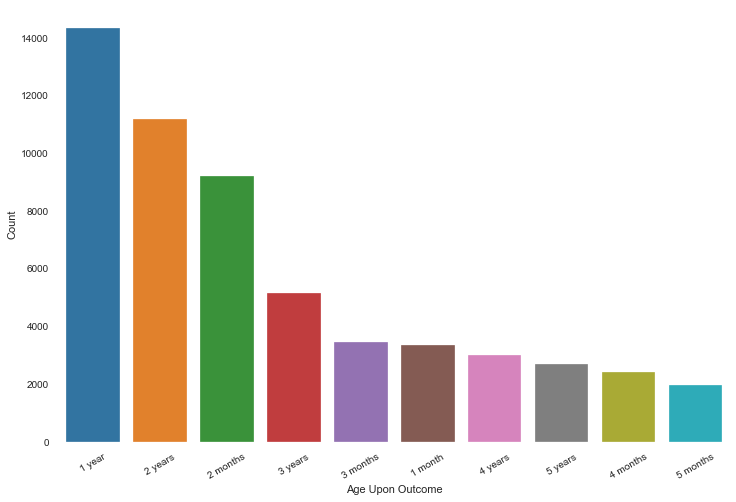

In [101]:
age_upon_outcome = aso['age_upon_outcome'].value_counts(dropna = False).head(10)
plt.figure(figsize=(12,8))
_ = sns.barplot(age_upon_outcome.index, age_upon_outcome.values)
plt.xlabel("Age Upon Outcome")
plt.ylabel("Count")
for item in _.get_xticklabels():
    item.set_rotation(30)
plt.show()

Здесь работаем с копией датасета:

In [292]:
df=df.loc[~df['age_upon_outcome'].isnull()]

In [293]:
df

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,date_of_birth_unix,datetime_unix,monthyear_unix,diff_date_unix,diff_date_timedelta
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male,1.404680e+09,1.406034e+09,1.406034e+09,1353840.0,"2.0 weeks, 1.0 day"
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female,1.352149e+09,1.383814e+09,1.383814e+09,31664820.0,"1.0 year, 1.0 day"
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male,1.364677e+09,1.401794e+09,1.401794e+09,37117200.0,"1.0 year, 2.0 months"
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male,1.117660e+09,1.402837e+09,1.402837e+09,285177000.0,"9.0 years, 1.0 week"
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown,1.389042e+09,1.404731e+09,1.404731e+09,15689040.0,"6.0 months, 5.0 days"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78250,1 month,A764895,Dog,Golden Retriever/Labrador Retriever,Brown/White,2017-12-04T00:00:00,2018-02-01T18:40:00,2018-02-01T18:40:00,NaN,Foster,Adoption,Neutered Male,1.512335e+09,1.517500e+09,1.517500e+09,5164800.0,"2.0 months, 1.0 day"
78251,1 month,A764894,Dog,Golden Retriever/Labrador Retriever,Brown/White,2017-12-04T00:00:00,2018-02-01T18:26:00,2018-02-01T18:26:00,NaN,Foster,Adoption,Spayed Female,1.512335e+09,1.517499e+09,1.517499e+09,5163960.0,"2.0 months, 1.0 day"
78252,3 years,A764468,Dog,Mastiff Mix,Blue/White,2014-12-30T00:00:00,2018-02-01T18:06:00,2018-02-01T18:06:00,Max,NaN,Adoption,Neutered Male,1.419887e+09,1.517498e+09,1.517498e+09,97610760.0,"3.0 years, 1.0 month"
78254,2 months,A765858,Dog,Standard Schnauzer,Red,2017-11-13T00:00:00,2018-02-01T18:32:00,2018-02-01T18:32:00,NaN,NaN,Adoption,Spayed Female,1.510520e+09,1.517499e+09,1.517499e+09,6978720.0,"2.0 months, 3.0 weeks"


**Удалили 8 NaN значений.**

### Атрибут №2  
'animal_id' - идентификатор животного (номер чипа животного)

In [76]:
aso['animal_id'].value_counts(dropna = False)

A718223    11
A706536    11
A721033    10
A694501     8
A616444     8
           ..
A686011     1
A673914     1
A689768     1
A729869     1
A746478     1
Name: animal_id, Length: 70855, dtype: int64

Несколько животных из набора данных были взяты в приют несколько раз, что создает дубликаты идентификаторов животных и вызывет проблемы при классификации и предсказывании меток.

In [71]:
type(aso['animal_id'].value_counts())

pandas.core.series.Series

In [97]:
atr_2[atr_2['animal_id']>1] #.reset_index()

,index,animal_id
0,A718223,11
1,A706536,11
2,A721033,10
3,A694501,8
4,A616444,8
...,...,...
5860,A708504,2
5861,A678084,2
5862,A696529,2
5863,A704454,2


In [184]:
atr_2 = aso['animal_id'].value_counts().reset_index()
atr_2

,index,animal_id
0,A706536,11
1,A718223,11
2,A721033,10
3,A716018,8
4,A616444,8
...,...,...
70850,A681098,1
70851,A715750,1
70852,A716288,1
70853,A661259,1


5865 различных животных были в приюте более одного раза.  
Первые пять строчек, совпадает с тем, что и показал профайлер, в этих данных число животных попадали в приют от 8 и более раз.

In [185]:
atr_2[atr_2['animal_id']>7] #.reset_index()

,index,animal_id
0,A706536,11
1,A718223,11
2,A721033,10
3,A716018,8
4,A616444,8
5,A694501,8


In [186]:
atr_2[atr_2['animal_id']>4] #.reset_index()

,index,animal_id
0,A706536,11
1,A718223,11
2,A721033,10
3,A716018,8
4,A616444,8
...,...,...
93,A735303,5
94,A613676,5
95,A697910,5
96,A689279,5


In [187]:
atr_2[atr_2['animal_id']>3] #.reset_index()

,index,animal_id
0,A706536,11
1,A718223,11
2,A721033,10
3,A716018,8
4,A616444,8
...,...,...
277,A714493,4
278,A689343,4
279,A711612,4
280,A708737,4


In [194]:
par = atr_2[atr_2['animal_id']>2]
par

,index,animal_id
0,A706536,11
1,A718223,11
2,A721033,10
3,A716018,8
4,A616444,8
...,...,...
1089,A701043,3
1090,A722562,3
1091,A685997,3
1092,A729015,3


In [196]:
df[df['animal_id']=='A706536']

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
33752,6 years,A706536,Dog,English Bulldog,Tan/White,2010-06-30T00:00:00,2016-11-29T12:26:00,2016-11-29T12:26:00,Butch,Partner,Transfer,Neutered Male
38680,5 years,A706536,Dog,English Bulldog,Tan/White,2010-06-30T00:00:00,2015-07-30T16:27:00,2015-07-30T16:27:00,Butch,NaN,Return to Owner,Neutered Male
44719,5 years,A706536,Dog,English Bulldog,Tan/White,2010-06-30T00:00:00,2015-10-28T11:34:00,2015-10-28T11:34:00,Butch,NaN,Return to Owner,Neutered Male
48700,5 years,A706536,Dog,English Bulldog,Tan/White,2010-06-30T00:00:00,2016-01-11T12:46:00,2016-01-11T12:46:00,Butch,NaN,Return to Owner,Neutered Male
54619,5 years,A706536,Dog,English Bulldog,Tan/White,2010-06-30T00:00:00,2015-07-03T12:49:00,2015-07-03T12:49:00,Butch,NaN,Return to Owner,Neutered Male
57689,5 years,A706536,Dog,English Bulldog,Tan/White,2010-06-30T00:00:00,2016-02-22T10:49:00,2016-02-22T10:49:00,Butch,NaN,Return to Owner,Neutered Male
63245,5 years,A706536,Dog,English Bulldog,Tan/White,2010-06-30T00:00:00,2015-07-20T12:50:00,2015-07-20T12:50:00,Butch,NaN,Return to Owner,Neutered Male
63413,5 years,A706536,Dog,English Bulldog,Tan/White,2010-06-30T00:00:00,2016-03-29T14:23:00,2016-03-29T14:23:00,Butch,NaN,Return to Owner,Neutered Male
66164,5 years,A706536,Dog,English Bulldog,Tan/White,2010-06-30T00:00:00,2016-03-18T19:32:00,2016-03-18T19:32:00,Butch,NaN,Return to Owner,Neutered Male
68044,5 years,A706536,Dog,English Bulldog,Tan/White,2010-06-30T00:00:00,2015-12-26T13:41:00,2015-12-26T13:41:00,Butch,NaN,Return to Owner,Neutered Male


In [197]:
df[df['animal_id']=='A718223']

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
27693,11 months,A718223,Dog,St. Bernard Rough Coat/Boxer,White/Brown,2015-05-24T00:00:00,2016-05-04T15:28:00,2016-05-04T15:28:00,Bubba,NaN,Return to Owner,Neutered Male
30590,7 months,A718223,Dog,St. Bernard Rough Coat/Boxer,White/Brown,2015-05-24T00:00:00,2016-01-12T15:35:00,2016-01-12T15:35:00,Bubba,NaN,Return to Owner,Neutered Male
35473,1 year,A718223,Dog,St. Bernard Rough Coat/Boxer,White/Brown,2015-05-24T00:00:00,2016-12-31T16:49:00,2016-12-31T16:49:00,Bubba,NaN,Return to Owner,Neutered Male
42759,2 years,A718223,Dog,St. Bernard Rough Coat/Boxer,White/Brown,2015-05-24T00:00:00,2017-09-20T17:30:00,2017-09-20T17:30:00,Bubba,NaN,Return to Owner,Neutered Male
48282,1 year,A718223,Dog,St. Bernard Rough Coat/Boxer,White/Brown,2015-05-24T00:00:00,2017-01-24T14:24:00,2017-01-24T14:24:00,Bubba,NaN,Return to Owner,Neutered Male
51347,2 years,A718223,Dog,St. Bernard Rough Coat/Boxer,White/Brown,2015-05-24T00:00:00,2017-12-08T16:25:00,2017-12-08T16:25:00,Bubba,NaN,Return to Owner,Neutered Male
64987,9 months,A718223,Dog,St. Bernard Rough Coat/Boxer,White/Brown,2015-05-24T00:00:00,2016-03-11T16:22:00,2016-03-11T16:22:00,Bubba,NaN,Return to Owner,Neutered Male
74678,2 years,A718223,Dog,St. Bernard Rough Coat/Boxer,White/Brown,2015-05-24T00:00:00,2017-08-25T11:24:00,2017-08-25T11:24:00,Bubba,NaN,Return to Owner,Neutered Male
75691,7 months,A718223,Dog,St. Bernard Rough Coat/Boxer,White/Brown,2015-05-24T00:00:00,2015-12-26T13:52:00,2015-12-26T13:52:00,Bubba,NaN,Return to Owner,Neutered Male
77105,2 years,A718223,Dog,St. Bernard Rough Coat/Boxer,White/Brown,2015-05-24T00:00:00,2018-01-06T15:55:00,2018-01-06T15:55:00,Bubba,NaN,Return to Owner,Neutered Male


In [198]:
df[df['animal_id']=='A721033']

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
27126,1 year,A721033,Dog,Rat Terrier Mix,Tricolor/Brown Brindle,2015-05-20T00:00:00,2017-01-28T15:22:00,2017-01-28T15:22:00,Lil Bit,NaN,Return to Owner,Neutered Male
31074,1 year,A721033,Dog,Rat Terrier Mix,Tricolor/Brown Brindle,2015-05-20T00:00:00,2017-01-10T16:20:00,2017-01-10T16:20:00,Lil Bit,NaN,Return to Owner,Neutered Male
43032,1 year,A721033,Dog,Rat Terrier Mix,Tricolor/Brown Brindle,2015-05-20T00:00:00,2016-09-12T13:40:00,2016-09-12T13:40:00,Lil Bit,NaN,Return to Owner,Neutered Male
47544,9 months,A721033,Dog,Rat Terrier Mix,Tricolor/Brown Brindle,2015-05-20T00:00:00,2016-02-20T16:18:00,2016-02-20T16:18:00,Lil Bit,NaN,Return to Owner,Neutered Male
48524,1 year,A721033,Dog,Rat Terrier Mix,Tricolor/Brown Brindle,2015-05-20T00:00:00,2017-02-07T17:26:00,2017-02-07T17:26:00,Lil Bit,NaN,Return to Owner,Neutered Male
56846,1 year,A721033,Dog,Rat Terrier Mix,Tricolor/Brown Brindle,2015-05-20T00:00:00,2017-03-16T12:50:00,2017-03-16T12:50:00,Lil Bit,NaN,Return to Owner,Neutered Male
59137,1 year,A721033,Dog,Rat Terrier Mix,Tricolor/Brown Brindle,2015-05-20T00:00:00,2016-10-21T18:55:00,2016-10-21T18:55:00,Lil Bit,NaN,Return to Owner,Neutered Male
65363,1 year,A721033,Dog,Rat Terrier Mix,Tricolor/Brown Brindle,2015-05-20T00:00:00,2016-12-16T11:32:00,2016-12-16T11:32:00,Lil Bit,NaN,Return to Owner,Neutered Male
68076,1 year,A721033,Dog,Rat Terrier Mix,Tricolor/Brown Brindle,2015-05-20T00:00:00,2016-07-11T17:44:00,2016-07-11T17:44:00,Lil Bit,NaN,Return to Owner,Neutered Male
74995,1 year,A721033,Dog,Rat Terrier Mix,Tricolor/Brown Brindle,2015-05-20T00:00:00,2017-02-02T11:19:00,2017-02-02T11:19:00,Lil Bit,NaN,Return to Owner,Neutered Male


In [199]:
df[df['animal_id']=='A701043']

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
35790,1 year,A701043,Dog,Staffordshire Mix,Fawn/White,2014-04-23T00:00:00,2016-04-12T13:09:00,2016-04-12T13:09:00,Chico,NaN,Adoption,Neutered Male
64622,2 years,A701043,Dog,Staffordshire Mix,Fawn/White,2014-04-23T00:00:00,2016-05-11T10:52:00,2016-05-11T10:52:00,Chico,Partner,Transfer,Neutered Male
64772,1 year,A701043,Dog,Staffordshire Mix,Fawn/White,2014-04-23T00:00:00,2015-05-08T12:47:00,2015-05-08T12:47:00,Chico,NaN,Return to Owner,Neutered Male


Доверяй, но проверяй, профайлер делает видимо только пять значений, а мы видим ещё одно животное, которое попало в приют восемь раз.

Эти животные явно не подходят для задачи классификации, если очень часто они были в приюте. Но, вот какие из них удалить?
Доверимся профайлеру и удалим следующие значения:

In [200]:
atr_2[atr_2['animal_id']>7]

,index,animal_id
0,A706536,11
1,A718223,11
2,A721033,10
3,A716018,8
4,A616444,8
5,A694501,8


A706536 A718223 A721033 A716018 A616444 A694501 Это проблемные животные, часто убегают от хозяев или с ними происходит что-нибудь ещё.

In [201]:
df[df['animal_id']=='A716018']

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
39775,1 year,A716018,Dog,Pit Bull Mix,Fawn/White,2015-06-14T00:00:00,2016-09-12T19:00:00,2016-09-12T19:00:00,Luke,NaN,Return to Owner,Neutered Male
45313,10 months,A716018,Dog,Pit Bull Mix,Fawn/White,2015-06-14T00:00:00,2016-05-10T15:49:00,2016-05-10T15:49:00,Luke,NaN,Adoption,Neutered Male
48634,5 months,A716018,Dog,Pit Bull Mix,Fawn/White,2015-06-14T00:00:00,2015-11-14T16:20:00,2015-11-14T16:20:00,Luke,NaN,Return to Owner,Intact Male
50599,2 years,A716018,Dog,Pit Bull Mix,Fawn/White,2015-06-14T00:00:00,2017-12-13T18:18:00,2017-12-13T18:18:00,Luke,NaN,Return to Owner,Neutered Male
51979,10 months,A716018,Dog,Pit Bull Mix,Fawn/White,2015-06-14T00:00:00,2016-04-30T18:01:00,2016-04-30T18:01:00,Luke,NaN,Adoption,Neutered Male
54736,1 year,A716018,Dog,Pit Bull Mix,Fawn/White,2015-06-14T00:00:00,2017-03-03T19:24:00,2017-03-03T19:24:00,Luke,NaN,Return to Owner,Neutered Male
62158,1 year,A716018,Dog,Pit Bull Mix,Fawn/White,2015-06-14T00:00:00,2017-03-05T16:50:00,2017-03-05T16:50:00,Luke,NaN,Return to Owner,Neutered Male
65888,1 year,A716018,Dog,Pit Bull Mix,Fawn/White,2015-06-14T00:00:00,2016-10-17T17:43:00,2016-10-17T17:43:00,Luke,NaN,Return to Owner,Neutered Male


На примере этого животного: надо смотреть последний случай, пока он наблюдается в приюте, всё-таки это "возвращение владельцу"

In [210]:
df.shape

(78248, 12)

Здесь работаем с копией датасета:

In [294]:
anid = ['A706536','A718223','A721033','A716018','A616444','A694501']
df=df.loc[~df['animal_id'].isin(anid)]

In [296]:
df.shape

(78192, 17)

### Атрибут №3  
'animal_type' - вид животного

[Немного о пирогах.](https://jenyay.net/Matplotlib/Pie)  

In [103]:
len(aso['animal_type'].value_counts())

5

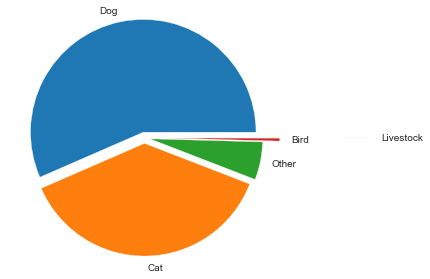

In [64]:
animal_type = aso['animal_type'].value_counts()
explode = (0.05, 0.05, 0.05, 0.2, 1)  # explode 1st slice (выдвигаем от центра)
# Plot
plt.pie(animal_type.values, explode=explode, labels=animal_type.index)
plt.axis('equal')
plt.tight_layout()
plt.show()

Собаки (**Dog**s) и кошки (**Cat**s) больше всего представлены. Меньше всего птицы (**Bird**s) и рогатый скот (**Livestock**).

In [109]:
len(aso[aso['animal_type']=='Livestock'])

9

In [ ]:
Здесь работаем с копией датасета:

In [214]:
df[df['animal_type']=='Livestock']

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
2240,6 months,A668167,Livestock,Pig Mix,Black/White,2013-05-28T00:00:00,2013-11-30T12:18:00,2013-11-30T12:18:00,NaN,NaN,Return to Owner,Intact Female
11609,6 months,A679540,Livestock,Goat Mix,Black,2013-11-22T00:00:00,2014-06-17T10:30:00,2014-06-17T10:30:00,NaN,Partner,Transfer,Intact Male
17291,5 years,A663228,Livestock,Miniature,Liver/Cream,2008-09-15T00:00:00,2013-10-03T10:59:00,2013-10-03T10:59:00,NaN,Partner,Transfer,Intact Male
19396,1 year,A673651,Livestock,Pig Mix,Black/White,2013-02-28T00:00:00,2014-03-11T14:39:00,2014-03-11T14:39:00,NaN,Foster,Adoption,Neutered Male
22609,5 weeks,A674214,Livestock,Pig Mix,Black,2014-02-22T00:00:00,2014-03-29T14:00:00,2014-03-29T14:00:00,NaN,Foster,Adoption,Unknown
31005,2 years,A701250,Livestock,Pig Mix,Pink,2013-04-26T00:00:00,2015-05-11T00:00:00,2015-05-11T00:00:00,NaN,Partner,Transfer,Intact Female
42901,1 year,A715047,Livestock,Goat Mix,Brown,2014-10-30T00:00:00,2015-12-07T00:00:00,2015-12-07T00:00:00,NaN,Partner,Transfer,Unknown
43388,7 months,A742204,Livestock,Potbelly Pig Mix,Black/White,2016-07-17T00:00:00,2017-03-15T12:49:00,2017-03-15T12:49:00,NaN,Partner,Transfer,Intact Female
60692,1 year,A718910,Livestock,Pig Mix,White,2015-01-09T00:00:00,2016-01-27T00:00:00,2016-01-27T00:00:00,NaN,Partner,Transfer,Intact Male


Наши атрибуты присутствуют, мало значений. Но оставим.

### Атрибут №4  
'breed' - порода животного

In [104]:
len(aso['breed'].value_counts())

2128

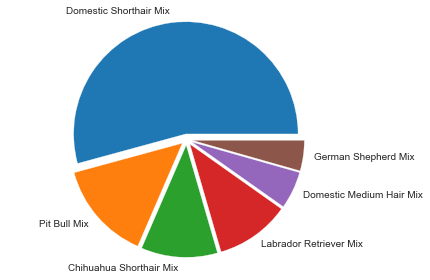

In [106]:
breed = aso['breed'].value_counts().head(6)
explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05)  # explode 1st slice
# Plot
plt.pie(breed.values, explode=explode, labels=breed.index)
plt.axis('equal')
plt.tight_layout()
plt.show()

Интересные вопросы, есть ли у рогатого скота порода? :)) Профайлер говорит, что NaN значений нет, то есть порода должна быть у всех. Всего значений у нас должно получиться 9 (см. Атрибут №3).

In [108]:
aso[aso['animal_type']=='Livestock']['breed']

2240              Pig Mix
11609            Goat Mix
17291           Miniature
19396             Pig Mix
22609             Pig Mix
31005             Pig Mix
42901            Goat Mix
43388    Potbelly Pig Mix
60692             Pig Mix
Name: breed, dtype: object

Действительно, порода есть у каждого из животных. Хоть двухголовый единорог.

<font color='red'>Атрибут 'Livestock' (Рогатый скот) столь незначителен и по сути отличается от других животных, его лучше дропнуть.</font>

### Атрибут №5  
'color' - окраска животного

In [110]:
len(aso['color'].value_counts())

525

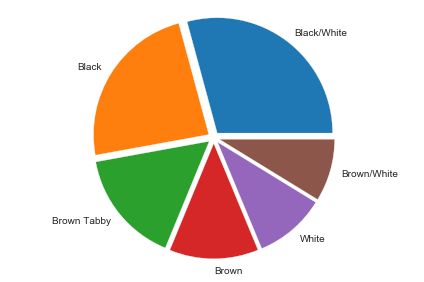

In [112]:
color = aso['color'].value_counts().head(6)
explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05)  # explode 1st slice
# Plot
plt.pie(color.values, explode=explode, labels=color.index)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [152]:
# Считаем количество цветов
df['color_cnt'] = df['color'].apply(lambda x: x.count('/'))
df['color_cnt'].value_counts()

1    40972
0    37284
Name: color_cnt, dtype: int64

In [153]:
40972 + 37284

78256

В сумме 78256 это хорошо. Но, есть ещё трехцветные животные. Нужно посмотреть сколько их, и при необходимости изменить некоторые значения.

In [134]:
df[df['color']=='Tricolor']

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,date_of_birth_unix,datetime_unix,monthyear_unix,diff_date_unix,diff_date_timedelta,color_cnt
119,1 year,A681482,Dog,Chihuahua Shorthair/Dachshund,Tricolor,2013-06-17T00:00:00,2014-06-26T12:26:00,2014-06-26T12:26:00,Chumino,Partner,Transfer,Intact Male,1.371416e+09,1.403775e+09,1.403775e+09,32358360.0,"1.0 year, 1.0 week",0
142,2 years,A691498,Dog,Australian Shepherd Mix,Tricolor,2012-11-05T00:00:00,2014-11-09T17:43:00,2014-11-09T17:43:00,Luna,NaN,Adoption,Spayed Female,1.352063e+09,1.415544e+09,1.415544e+09,63481380.0,"2.0 years, 4.0 days",0
146,4 years,A690027,Dog,Boxer Mix,Tricolor,2010-10-13T00:00:00,2014-10-18T13:41:00,2014-10-18T13:41:00,Harley,NaN,Return to Owner,Spayed Female,1.286917e+09,1.413629e+09,1.413629e+09,126711660.0,"4.0 years, 5.0 days",0
187,3 years,A675315,Dog,Dachshund Wirehair Mix,Tricolor,2011-03-26T00:00:00,2014-04-02T15:48:00,2014-04-02T15:48:00,*Greta,NaN,Adoption,Spayed Female,1.301087e+09,1.396443e+09,1.396443e+09,95356080.0,"3.0 years, 1.0 week",0
251,10 months,A669279,Dog,Anatol Shepherd Mix,Tricolor,2013-02-17T00:00:00,2013-12-24T15:33:00,2013-12-24T15:33:00,Sagan,NaN,Adoption,Neutered Male,1.361048e+09,1.387888e+09,1.387888e+09,26839980.0,"10.0 months, 2.0 weeks",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77924,2 months,A764272,Dog,Collie Smooth Mix,Tricolor,2017-11-22T00:00:00,2018-01-25T16:08:00,2018-01-25T16:08:00,Harley,Foster,Adoption,Neutered Male,1.511298e+09,1.516886e+09,1.516886e+09,5587680.0,"2.0 months, 6.0 days",0
77938,1 year,A765399,Dog,Australian Cattle Dog Mix,Tricolor,2016-10-19T00:00:00,2018-01-25T19:07:00,2018-01-25T19:07:00,NaN,NaN,Adoption,Neutered Male,1.476824e+09,1.516896e+09,1.516896e+09,40072020.0,"1.0 year, 3.0 months",0
77986,2 years,A765746,Dog,Jack Russell Terrier Mix,Tricolor,2016-01-26T00:00:00,2018-01-27T13:20:00,2018-01-27T13:20:00,Anya,NaN,Return to Owner,Spayed Female,1.453756e+09,1.517048e+09,1.517048e+09,63292800.0,"2.0 years, 2.0 days",0
78160,2 months,A764650,Dog,Boxer Mix,Tricolor,2017-11-19T00:00:00,2018-01-31T07:41:00,2018-01-31T07:41:00,*Maggie,Foster,Adoption,Spayed Female,1.511039e+09,1.517374e+09,1.517374e+09,6334860.0,"2.0 months, 2.0 weeks",0


In [172]:
df['color_cnt'] = 1

In [173]:
df['color_cnt'][df['color'].str.contains('/')] = 2

In [174]:
df['color_cnt'][df['color'].str.contains('Tricolor')] = 3

In [175]:
df['color_cnt'].value_counts()

2    40501
1    35302
3     2453
Name: color_cnt, dtype: int64

In [177]:
40501 + 35302 + 2453

78256

In [180]:
df[df['color_cnt']==3]

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,date_of_birth_unix,datetime_unix,monthyear_unix,diff_date_unix,diff_date_timedelta,color_cnt
95,14 years,A562649,Dog,Border Collie Mix,White/Tricolor,2000-03-20T00:00:00,2014-03-20T18:37:00,2014-03-20T18:37:00,NaN,Suffering,Euthanasia,Spayed Female,9.534996e+08,1.395330e+09,1.395330e+09,441830220.0,"14.0 years, 6.0 hours",3
119,1 year,A681482,Dog,Chihuahua Shorthair/Dachshund,Tricolor,2013-06-17T00:00:00,2014-06-26T12:26:00,2014-06-26T12:26:00,Chumino,Partner,Transfer,Intact Male,1.371416e+09,1.403775e+09,1.403775e+09,32358360.0,"1.0 year, 1.0 week",3
142,2 years,A691498,Dog,Australian Shepherd Mix,Tricolor,2012-11-05T00:00:00,2014-11-09T17:43:00,2014-11-09T17:43:00,Luna,NaN,Adoption,Spayed Female,1.352063e+09,1.415544e+09,1.415544e+09,63481380.0,"2.0 years, 4.0 days",3
145,2 months,A678589,Dog,German Shepherd/Pembroke Welsh Corgi,Tricolor/Brown,2014-03-02T00:00:00,2014-05-17T12:12:00,2014-05-17T12:12:00,NaN,NaN,Adoption,Neutered Male,1.393708e+09,1.400318e+09,1.400318e+09,6610320.0,"2.0 months, 2.0 weeks",3
146,4 years,A690027,Dog,Boxer Mix,Tricolor,2010-10-13T00:00:00,2014-10-18T13:41:00,2014-10-18T13:41:00,Harley,NaN,Return to Owner,Spayed Female,1.286917e+09,1.413629e+09,1.413629e+09,126711660.0,"4.0 years, 5.0 days",3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78148,6 months,A765421,Dog,Australian Cattle Dog Mix,Blue Merle/Tricolor,2017-07-20T00:00:00,2018-01-30T16:52:00,2018-01-30T16:52:00,Wrangler,NaN,Return to Owner,Intact Male,1.500498e+09,1.517320e+09,1.517320e+09,16822320.0,"6.0 months, 2.0 weeks",3
78160,2 months,A764650,Dog,Boxer Mix,Tricolor,2017-11-19T00:00:00,2018-01-31T07:41:00,2018-01-31T07:41:00,*Maggie,Foster,Adoption,Spayed Female,1.511039e+09,1.517374e+09,1.517374e+09,6334860.0,"2.0 months, 2.0 weeks",3
78176,7 years,A764962,Dog,Beagle Mix,Tricolor,2011-01-10T00:00:00,2018-01-31T14:43:00,2018-01-31T14:43:00,Sophie,NaN,Return to Owner,Spayed Female,1.294607e+09,1.517399e+09,1.517399e+09,222792180.0,"7.0 years, 3.0 weeks",3
78188,1 year,A766024,Dog,Australian Cattle Dog Mix,Tricolor/Blue Merle,2016-07-31T00:00:00,2018-01-31T16:39:00,2018-01-31T16:39:00,Princess,NaN,Return to Owner,Spayed Female,1.469912e+09,1.517406e+09,1.517406e+09,47493540.0,"1.0 year, 6.0 months",3


Интересное наблюдение. В первоначальном датасете чисто трехцветных (Tricolor) 1982 экземпляра. Если учесть, что к трехцветному добавляется ещё один цвет в качестве основы (Tricolor/цвет или цвет/Tricolor), то количество животных увеличится до 2453. Будем считать, что более общюю группу трехцветными. То есть дальше разбивать не будем.

In [181]:
df['color_cnt'].value_counts()

2    40501
1    35302
3     2453
Name: color_cnt, dtype: int64

Будем считать, что у нас одноцветные, двухцветные животные. И многоцветные (с количеством цветов от трёх).

In [178]:
df.sample(10)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,date_of_birth_unix,datetime_unix,monthyear_unix,diff_date_unix,diff_date_timedelta,color_cnt
39559,2 months,A734382,Cat,Domestic Shorthair Mix,Brown Tabby,2016-07-21T00:00:00,2016-10-04T16:08:00,2016-10-04T16:08:00,NaN,NaN,Adoption,Neutered Male,1.469048e+09,1.475586e+09,1.475586e+09,6538080.0,"2.0 months, 2.0 weeks",1
35197,1 year,A735431,Cat,Domestic Medium Hair Mix,Brown Tabby,2016-01-23T00:00:00,2017-01-24T19:03:00,2017-01-24T19:03:00,*Bellatrix,NaN,Adoption,Spayed Female,1.453496e+09,1.485274e+09,1.485274e+09,31777380.0,"1.0 year, 2.0 days",1
16596,5 months,A674165,Dog,Pointer/Ibizan Hound,Red/White,2013-10-08T00:00:00,2014-03-15T17:07:00,2014-03-15T17:07:00,*Isis,NaN,Adoption,Spayed Female,1.381180e+09,1.394892e+09,1.394892e+09,13712820.0,"5.0 months, 1.0 week",2
36851,1 year,A754094,Dog,Boxer Mix,Brown Brindle/White,2016-07-15T00:00:00,2017-08-01T15:13:00,2017-08-01T15:13:00,*Rory,Partner,Transfer,Neutered Male,1.468530e+09,1.501590e+09,1.501590e+09,33059580.0,"1.0 year, 2.0 weeks",2
13005,6 years,A683689,Dog,Catahoula Mix,Brown Merle,2007-09-16T00:00:00,2014-07-23T13:07:00,2014-07-23T13:07:00,Riley,NaN,Return to Owner,Spayed Female,1.189890e+09,1.406110e+09,1.406110e+09,216220020.0,"6.0 years, 10.0 months",1
16237,3 years,A675541,Cat,Domestic Shorthair Mix,Brown Tabby,2011-03-28T00:00:00,2014-08-20T14:55:00,2014-08-20T14:55:00,Caprice,Partner,Transfer,Spayed Female,1.301260e+09,1.408536e+09,1.408536e+09,107276100.0,"3.0 years, 4.0 months",1
53599,2 years,A748445,Dog,Labrador Retriever Mix,Black,2015-05-03T00:00:00,2017-05-06T14:57:00,2017-05-06T14:57:00,Ellie,NaN,Adoption,Spayed Female,1.430600e+09,1.494072e+09,1.494072e+09,63471420.0,"2.0 years, 4.0 days",1
77609,3 years,A741374,Dog,Pit Bull Mix,Brown Brindle/White,2013-12-31T00:00:00,2017-01-14T17:00:00,2017-01-14T17:00:00,*Pavarotti,NaN,Return to Owner,Intact Male,1.388437e+09,1.484402e+09,1.484402e+09,95965200.0,"3.0 years, 2.0 weeks",2
4865,3 months,A683121,Cat,Domestic Shorthair,Blue Tabby/White,2014-03-31T00:00:00,2014-07-08T11:58:00,2014-07-08T11:58:00,NaN,Partner,Transfer,Intact Female,1.396213e+09,1.404810e+09,1.404810e+09,8596680.0,"3.0 months, 1.0 week",2
7610,1 month,A673617,Dog,Keeshond Mix,Sable/White,2014-01-08T00:00:00,2014-03-09T17:35:00,2014-03-09T17:35:00,NaN,Partner,Transfer,Spayed Female,1.389128e+09,1.394376e+09,1.394376e+09,5247300.0,"2.0 months, 2.0 days",2


Здесь работаем с копией датасета (после дропа в атрибутах №№ 1 и 2):

In [216]:
df.shape

(78192, 12)

In [ ]:
Повторим назначение нового столбца (градация по цвету)

In [306]:
df['color_cnt'] = 1

In [307]:
df['color_cnt'][df['color'].str.contains('/')] = 2

In [308]:
df['color_cnt'][df['color'].str.contains('Tricolor')] = 3

In [221]:
df['color_cnt'].value_counts()

2    40459
1    35290
3     2443
Name: color_cnt, dtype: int64

In [222]:
df.sample(10)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,color_cnt
71405,1 year,A742282,Dog,Labrador Retriever Mix,Black/White,2015-11-18T00:00:00,2017-03-10T13:59:00,2017-03-10T13:59:00,Captainameri,Partner,Transfer,Intact Male,2
45692,1 year,A744999,Other,Bat Mix,Brown,2016-03-11T00:00:00,2017-03-11T08:46:00,2017-03-11T08:46:00,NaN,Rabies Risk,Euthanasia,Unknown,1
39332,1 year,A729059,Dog,Standard Poodle Mix,White,2015-06-13T00:00:00,2016-06-17T14:32:00,2016-06-17T14:32:00,Ochie,NaN,Return to Owner,Intact Male,1
19581,10 years,A465573,Dog,Labrador Retriever/Chow Chow,Black/Brown,2003-03-22T00:00:00,2014-02-03T18:03:00,2014-02-03T18:03:00,Boly,NaN,Return to Owner,Neutered Male,2
10897,4 years,A677995,Cat,Russian Blue Mix,Blue,2010-05-02T00:00:00,2014-05-04T13:13:00,2014-05-04T13:13:00,NaN,SCRP,Transfer,Intact Male,1
26688,1 year,A695541,Cat,Domestic Shorthair Mix,Brown Tabby/White,2014-01-17T00:00:00,2015-01-18T09:00:00,2015-01-18T09:00:00,NaN,SCRP,Transfer,Intact Female,2
46658,11 years,A462504,Dog,Pit Bull Mix,Red/White,2005-02-22T00:00:00,2017-02-09T09:39:00,2017-02-09T09:39:00,Lady Bug,Foster,Adoption,Spayed Female,2
9817,5 years,A679499,Cat,Domestic Shorthair Mix,Black/White,2009-05-21T00:00:00,2014-05-22T17:57:00,2014-05-22T17:57:00,Panda,NaN,Return to Owner,Neutered Male,2
16057,3 years,A692832,Dog,German Shepherd,Black,2011-11-26T00:00:00,2014-12-04T17:19:00,2014-12-04T17:19:00,Lady,Partner,Transfer,Spayed Female,1
53994,6 years,A562221,Dog,Pit Bull Mix,Fawn/White,2009-04-05T00:00:00,2015-05-17T17:06:00,2015-05-17T17:06:00,Silver,Aggressive,Euthanasia,Spayed Female,2


- - -

In [224]:
df[df['color_cnt']==3].sample(5)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,color_cnt
51687,4 years,A740810,Dog,Bernese Mountain Dog Mix,Tricolor/Brown,2012-12-23T00:00:00,2017-09-26T00:00:00,2017-09-26T00:00:00,Ben,Partner,Transfer,Neutered Male,3
33504,8 years,A608349,Dog,Rat Terrier Mix,White/Tricolor,2007-03-22T00:00:00,2015-09-17T11:56:00,2015-09-17T11:56:00,Olivia,NaN,Adoption,Spayed Female,3
49876,2 years,A736823,Dog,Parson Russell Terrier Mix,Tricolor,2014-10-17T00:00:00,2016-10-23T00:00:00,2016-10-23T00:00:00,*Charlie,Partner,Transfer,Neutered Male,3
5640,1 month,A689601,Dog,Miniature Pinscher/Chihuahua Shorthair,Tricolor,2014-09-29T00:00:00,2014-11-23T18:55:00,2014-11-23T18:55:00,*Abby,Foster,Adoption,Spayed Female,3
20819,3 years,A680525,Dog,Boxer/Australian Cattle Dog,Tricolor,2011-06-03T00:00:00,2014-09-22T12:16:00,2014-09-22T12:16:00,Kendall,Partner,Transfer,Spayed Female,3


### Рассмотрим  теперь атрибуты №№ 6, 7, 8.    
Сравним друг с другом и рассмотрим отдельно. Вспомним, что в этих атрибутах нет NaN значений, все строчки заполнены. Совпадения внутри значений у каждого из атрибутов нам не интересны, потому что там есть некоторые даты, события в которых могут повторяться. Может, конечно, быть особый день, в которых этих событий больше, чем в другой, не более того.

Убедимся, что в атрибутах 'datetime' и 'monthyear' все ячейки совпадают по значениям (100% корреляция).

In [8]:
aso[aso['datetime'] != aso['monthyear']]

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome


In [ ]:
По сути это один и тот же столбец, только под другим названием.

Наоборот, убедимся, что в атрибутах 'date_of_birth' и 'datetime' ('monthyear') нет совпадений.

In [11]:
len(aso[aso['date_of_birth'] != aso['datetime']])

78256

Видно, что количество несовпадений соответствует количеству строк датасета.

---

Атрибуты №№6, 7, 8 представлены полностью. Есть предположение, что атрибут №1 является разницей между Атрибутом №7 (он же №8) и атрибутом №6, в случае, если животное родилось в приюте. Правда по какой-то причине есть 8 - Nan значений атрибута №1. Мне даже важно знать не атрибуты 'date_of_birth' и 'datetime', а их разницу, также ценен атрибут №1 'age_upon_outcome'.

In [289]:
import time
from datetime import date
from datetime import datetime
from datetime import timedelta

df = aso.copy()
# Пусть будет 2010 год в качестве точки отсчета (потом можно заскелить)
#d = date(2010, 1, 1)

#unixtime_0 = time.mktime(d.timetuple()) 

def get_unix_time(value):
    dt = datetime.strptime(value, '%Y-%m-%dT%H:%M:%S')
    unixtime = time.mktime(dt.timetuple())
    return unixtime # (unixtime - unixtime_0)

intervals = (
    ('years', 31557600), # 60 * 60 * 24 * 365.25
    ('months', 2531520), # 60 * 60 * 24 * 29.3
    ('weeks', 604800),  # 60 * 60 * 24 * 7
    ('days', 86400),    # 60 * 60 * 24
    ('hours', 3600),    # 60 * 60
    ('minutes', 60),
    ('seconds', 1),
    )

def display_time(seconds, granularity=2):
    result = []

    for name, count in intervals:
        value = seconds // count
        if value:
            seconds -= value * count
            if value == 1:
                name = name.rstrip('s')
            result.append("{} {}".format(value, name))
    return ', '.join(result[:granularity])


# Добавим колонки с UNIX временем
df['date_of_birth_unix'] = df['date_of_birth'].apply(get_unix_time)
df['datetime_unix'] = df['datetime'].apply(get_unix_time)
df['monthyear_unix'] = df['monthyear'].apply(get_unix_time)

# Добавим колонку разницы между 'datetime_unix' и 'date_of_birth_unix'
df['diff_date_unix'] = df['datetime_unix'] - df['date_of_birth_unix']

df['diff_date_timedelta'] = df['diff_date_unix'].apply(display_time, 4)


#timedelta(df['diff_date_unix'])


df.head()
#df[['date_of_birth_unix', 'datetime_unix', 'monthyear_unix']].head(10)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,date_of_birth_unix,datetime_unix,monthyear_unix,diff_date_unix,diff_date_timedelta
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male,1.404680e+09,1.406034e+09,1.406034e+09,1353840.0,"2.0 weeks, 1.0 day"
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female,1.352149e+09,1.383814e+09,1.383814e+09,31664820.0,"1.0 year, 1.0 day"
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male,1.364677e+09,1.401794e+09,1.401794e+09,37117200.0,"1.0 year, 2.0 months"
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male,1.117660e+09,1.402837e+09,1.402837e+09,285177000.0,"9.0 years, 1.0 week"
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown,1.389042e+09,1.404731e+09,1.404731e+09,15689040.0,"6.0 months, 5.0 days"


In [290]:
df.sample(5)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,date_of_birth_unix,datetime_unix,monthyear_unix,diff_date_unix,diff_date_timedelta
4778,7 years,A679082,Dog,Bloodhound Mix,Red,2007-05-16T00:00:00,2014-05-16T12:39:00,2014-05-16T12:39:00,Ragnar,NaN,Return to Owner,Neutered Male,1.179263e+09,1.400233e+09,1.400233e+09,220970340.0,"7.0 years, 18.0 hours"
9164,1 year,A675021,Cat,Domestic Shorthair Mix,Calico,2013-03-21T00:00:00,2014-03-21T17:09:00,2014-03-21T17:09:00,NaN,Suffering,Euthanasia,Intact Female,1.363813e+09,1.395411e+09,1.395411e+09,31597740.0,"1.0 year, 11.0 hours"
14121,2 years,A691574,Dog,Labrador Retriever Mix,Black/White,2012-11-06T00:00:00,2014-11-09T17:36:00,2014-11-09T17:36:00,Boing,NaN,Return to Owner,Neutered Male,1.352149e+09,1.415544e+09,1.415544e+09,63394560.0,"2.0 years, 3.0 days"
77958,4 years,A668142,Dog,Labrador Retriever Mix,Chocolate/White,2013-10-05T00:00:00,2018-01-26T15:29:00,2018-01-26T15:29:00,Sox,NaN,Return to Owner,Spayed Female,1.380920e+09,1.516970e+09,1.516970e+09,136049340.0,"4.0 years, 3.0 months"
14679,10 months,A684786,Dog,Border Collie/Catahoula,Brown Merle/White,2013-09-28T00:00:00,2014-08-03T15:47:00,2014-08-03T15:47:00,*Reno,Partner,Transfer,Intact Male,1.380316e+09,1.407070e+09,1.407070e+09,26754420.0,"10.0 months, 2.0 weeks"


---

timedelta работает максимум с днями. Поэтому вот пришлось использовать функцию display_time, она не очень точная, но показывает, что 'age_upon_time' это разница между 'datetime' и 'date_of_birth'.  
**И скорей всего 'date_of_birth' это условный день рождения - дата, когда животное первый раз появилось в приюте.**

Для анализа нужно использовать числовые значения, пусть всё-таки diff_date_timedelta будет найден через timedelta и выражен в днях или оставим в секундах.

### Атрибут №6  
'date_of_birth' - дата рождения

### Атрибут №7  
'datetime' - дата-время

### Атрибут №8  
'monthyear' - месяц-год

Стоит дропнуть.

### Атрибут №9  
'name' - кличка

**Сразу стоит отметить, что профайлер показал 23886 NaN значений.** <font color='red'>очень много</font> Лучше для безымяшек отдельный атрибут создать.

In [237]:
aso['name'].value_counts(dropna = False).head(11)

NaN         23886
Bella         344
Max           319
Luna          239
Rocky         236
Princess      235
Daisy         233
Charlie       211
Lucy          206
Buddy         201
Coco          186
Name: name, dtype: int64

Посчитаем, сколько всего уникальных  кличек.

In [163]:
len(aso['name'].value_counts(dropna = True))

14574

In [234]:
aso['name'].value_counts(dropna = False)>200

NaN                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     True
Bella                                                                                                                                                                                                                                                                                                      

<font color='magenta'>Здесь случай такой, что лучше задать пустым ячейкам какое-нибудь значение, иначе потеряем очень много информации. Можно написать например 'Unknown' или иначе.</font>

In [66]:
aso[aso.name.str.contains('\*.*', na=False)]

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
5,4 months,A664462,Dog,Leonberger Mix,Brown/White,2013-06-03T00:00:00,2013-10-07T13:06:00,2013-10-07T13:06:00,*Edgar,Partner,Transfer,Intact Male
7,3 years,A692618,Dog,Chihuahua Shorthair Mix,Brown,2011-11-23T00:00:00,2014-12-08T15:55:00,2014-12-08T15:55:00,*Ella,Partner,Transfer,Spayed Female
9,3 months,A678580,Cat,Domestic Shorthair Mix,White/Black,2014-03-26T00:00:00,2014-06-29T17:45:00,2014-06-29T17:45:00,*Frida,Offsite,Adoption,Spayed Female
15,2 years,A680396,Dog,Rat Terrier Mix,White/Black,2012-06-02T00:00:00,2014-06-15T15:11:00,2014-06-15T15:11:00,*Truman,Partner,Transfer,Neutered Male
...,...,...,...,...,...,...,...,...,...,...,...,...
78178,2 years,A765753,Dog,Pit Bull Mix,White/Brown,2016-01-26T00:00:00,2018-01-31T15:52:00,2018-01-31T15:52:00,*Peach,Partner,Transfer,Intact Female
78182,2 years,A765368,Dog,German Shepherd Mix,Sable,2016-01-18T00:00:00,2018-01-31T16:26:00,2018-01-31T16:26:00,*Della,NaN,Adoption,Spayed Female
78209,10 years,A759029,Dog,Queensland Heeler Mix,White/Blue Merle,2007-09-25T00:00:00,2018-02-01T10:39:00,2018-02-01T10:39:00,*Frida,Foster,Adoption,Spayed Female
78215,1 year,A763760,Dog,Border Collie Mix,Chocolate/White,2016-12-15T00:00:00,2018-02-01T12:05:00,2018-02-01T12:05:00,*Eggnog,Foster,Adoption,Neutered Male


In [72]:
markednames=aso[aso.name.str.contains('\*.*', na=False)]['outcome_type']

In [77]:
markednames[markednames == 'Adoption']

2        Adoption
9        Adoption
18       Adoption
23       Adoption
36       Adoption
           ...   
78175    Adoption
78182    Adoption
78209    Adoption
78215    Adoption
78218    Adoption
Name: outcome_type, Length: 12095, dtype: object

In [78]:
markednames[markednames == 'Transfer']

5        Transfer
7        Transfer
15       Transfer
16       Transfer
24       Transfer
           ...   
78134    Transfer
78136    Transfer
78149    Transfer
78152    Transfer
78178    Transfer
Name: outcome_type, Length: 5730, dtype: object

In [80]:
mn_Ad_Tr = len(markednames[markednames == 'Adoption'])+len(markednames[markednames == 'Transfer'])
mn_Ad_Tr

17825

In [82]:
len(markednames) - mn_Ad_Tr

788

Предварительный анализ, даже без использования методов выявляет, что если в именах есть звёздочка * впереди, то скорей всего это один из наших случаев. Adoption или Transfer. По крайней мере здесь процентное соотношение искомых меток намного больше остальных случаев, если сравнивать с первоначальным датасетом (рассматриваю отдельно, как атрибут №11).

In [86]:
markednames.value_counts()

Adoption           12095
Transfer            5730
Euthanasia           334
Return to Owner      281
Died                 139
Missing               23
Rto-Adopt              6
Name: outcome_type, dtype: int64

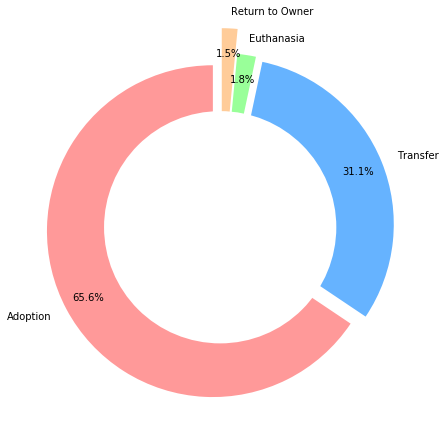

In [85]:
outcome_type_mn = markednames.value_counts().head(4)
plt.figure(figsize=(6,6))
#colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
#explsion
explode = (0.05,0.05,0.05,0.2)
plt.pie(outcome_type_mn, colors = colors, labels=outcome_type_mn.index, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  
plt.tight_layout()
plt.show()

Здесь работаем с копией датасета:

In [227]:
df.shape # в процессе количество строк не должно измениться,
         # мы не дропаем имена, а создаём группы

(78192, 13)

Сделаем из первоначального столбика с именами, столбик по группам. Например, маркированные имена, редкие имена (Other_name), и превратим NaN-значения в тип Unknown.

In [238]:
aso['name'].value_counts(dropna = False).head(11)

NaN         23886
Bella         344
Max           319
Luna          239
Rocky         236
Princess      235
Daisy         233
Charlie       211
Lucy          206
Buddy         201
Coco          186
Name: name, dtype: int64

In [265]:
df.loc[~df['name'].isna(), 'name_new'] = df['name']
df.loc[df['name'].isna(), 'name_new'] = 'Unknown'
   #df.loc[df['name_new'].isnull() , 'name_new'] = df['name']
df.loc[df['name'].str.contains('\*.*', na=False) , 'name_new'] = 'Marked_name'

df['name_new'].value_counts().head()

Unknown        23880
Marked_name    18611
Bella            344
Max              319
Luna             239
Name: name_new, dtype: int64

In [269]:
len(df['name_new'])

78192

In [268]:
df.shape

(78192, 14)

### Атрибут №10  
'outcome_subtype' - **Что означает?**

**Сразу стоит отметить, что профайлер показал 42293 NaN значений.** <font color='red'>очень много</font>

<font color='red'>Данный атрибут 'outcome_subtype' имеет сильную корреляцию с целевым атрибутом 'outcome_type' (там находятся нужные метки) и, вероятно, его стоит дропнуть.</font>

In [157]:
aso['outcome_subtype'].value_counts(dropna = False)

NaN                    42293
Partner                19660
Foster                  5558
SCRP                    3211
Suffering               2514
Rabies Risk             2417
Snr                      626
Aggressive               506
Offsite                  367
In Kennel                343
Medical                  259
In Foster                182
Behavior                 142
At Vet                    59
Enroute                   45
Underage                  28
Court/Investigation       18
In Surgery                16
Possible Theft             9
Barn                       3
Name: outcome_subtype, dtype: int64

<font color='green'>Интересно по атрибуту №10 и №11 провести соотвествие, какие значения принимает атрибут 'outcome_subtype' (№10), если атрибут 'outcome_type' (№11) принимает целевые метки 'Adoption' и 'Transfer'!</font>

<font color='magenta'>В процессе: стоит, не стоит. Или дропнуть.</font>

Здесь работаем с копией датасета:

Оставим этот атрибут, заменим Nan-значения значением 'Unknown'

In [271]:
df.shape

(78192, 14)

In [272]:
df['outcome_subtype'].value_counts(dropna = False)

NaN                    42236
Partner                19657
Foster                  5558
SCRP                    3211
Suffering               2511
Rabies Risk             2416
Snr                      626
Aggressive               506
Offsite                  367
In Kennel                343
Medical                  259
In Foster                182
Behavior                 142
At Vet                    59
Enroute                   45
Underage                  28
Court/Investigation       18
In Surgery                16
Possible Theft             9
Barn                       3
Name: outcome_subtype, dtype: int64

In [273]:
df.loc[df['outcome_subtype'].isna(), 'outcome_subtype'] = 'Unknown'

In [274]:
df['outcome_subtype'].value_counts(dropna = False)

Unknown                42236
Partner                19657
Foster                  5558
SCRP                    3211
Suffering               2511
Rabies Risk             2416
Snr                      626
Aggressive               506
Offsite                  367
In Kennel                343
Medical                  259
In Foster                182
Behavior                 142
At Vet                    59
Enroute                   45
Underage                  28
Court/Investigation       18
In Surgery                16
Possible Theft             9
Barn                       3
Name: outcome_subtype, dtype: int64

 Теперь можем полноценно работать с этим атрибутом.

### Атрибут №11  
'outcome_type' - **Что означает?**

**Сразу стоит отметить, что профайлер показал двенадцать NaN значений.**

In [148]:
aso['outcome_type'].value_counts(dropna = False)

Adoption           33112
Transfer           23499
Return to Owner    14354
Euthanasia          6080
Died                 680
Disposal             307
Rto-Adopt            150
Missing               46
Relocate              16
NaN                   12
Name: outcome_type, dtype: int64

In [153]:
aso['outcome_type'].value_counts(dropna = True).sum()

78244

In [152]:
len(aso['outcome_type'])

78256

In [150]:
len(aso['outcome_type'].value_counts())

9

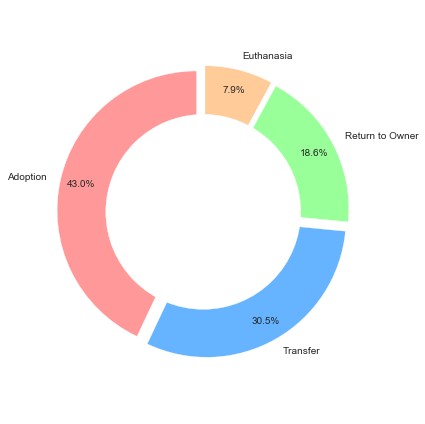

In [156]:
outcome_type = aso['outcome_type'].value_counts().head(4)
plt.figure(figsize=(6,6))
#colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
#explsion
explode = (0.05,0.05,0.05,0.05)
plt.pie(outcome_type, colors = colors, labels=outcome_type.index, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  
plt.tight_layout()
plt.show()

Посмотрим строки, в которых есть NaN-значения.

In [154]:
aso[aso['outcome_type'].isnull()]

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
10753,1 year,A671017,Other,Fox Mix,Brown/Black,2013-01-17T00:00:00,2014-01-20T08:27:00,2014-01-20T08:27:00,NaN,NaN,NaN,Unknown
13270,0 years,A674209,Other,Bat Mix,Brown,2014-03-09T00:00:00,2014-03-09T18:15:00,2014-03-09T18:15:00,NaN,NaN,NaN,Unknown
13302,4 weeks,A679066,Other,Rabbit Sh,Brown,2014-04-16T00:00:00,2014-05-16T00:00:00,2014-05-16T00:00:00,NaN,NaN,NaN,Unknown
16951,1 year,A686025,Other,Bat Mix,Brown,2013-08-15T00:00:00,2014-08-16T08:35:00,2014-08-16T08:35:00,NaN,NaN,NaN,Unknown
29214,1 year,A744013,Other,Bat Mix,Black,2016-02-21T00:00:00,2017-02-24T09:00:00,2017-02-24T09:00:00,NaN,NaN,NaN,Unknown
64626,1 month,A755711,Cat,Domestic Shorthair Mix,Black,2017-07-06T00:00:00,2017-08-21T10:09:00,2017-08-21T10:09:00,*Dewey,NaN,NaN,Intact Male
68246,NaN,A737705,Dog,Labrador Retriever Mix,Black/White,2013-11-02T00:00:00,2016-11-19T16:35:00,2016-11-19T16:35:00,*Heddy,NaN,NaN,NaN
69847,1 month,A755715,Cat,Domestic Shorthair Mix,Black Smoke,2017-06-29T00:00:00,2017-08-21T10:09:00,2017-08-21T10:09:00,*Louie,NaN,NaN,Intact Female
72037,1 month,A755716,Cat,Domestic Shorthair Mix,Blue,2017-07-06T00:00:00,2017-08-21T10:09:00,2017-08-21T10:09:00,*Huey,NaN,NaN,Intact Female
76709,10 years,A718046,Dog,Chihuahua Longhair Mix,Cream,2005-12-20T00:00:00,2016-03-26T00:00:00,2016-03-26T00:00:00,Bailey,NaN,NaN,Neutered Male


Здесь работаем с копией датасета:

In [275]:
df.shape

(78192, 14)

In [ ]:
Данные строки не информативны, следует удалить.

In [297]:
df=df.loc[~df['outcome_type'].isnull()]

In [298]:
df.shape

(78182, 17)

In [299]:
df[df['outcome_type'].isnull()].shape

(0, 17)

### Атрибут №12  
'sex_upon_outcome' - принадлежность полу животного

**Сразу стоит отметить, что профайлер показал два NaN значения.**

In [118]:
aso['sex_upon_outcome'].value_counts(dropna = False)

Neutered Male    27784
Spayed Female    25203
Intact Male       9549
Intact Female     9143
Unknown           6575
NaN                  2
Name: sex_upon_outcome, dtype: int64

In [155]:
aso['sex_upon_outcome'].value_counts(dropna = True).sum()

78254

In [122]:
len(aso['sex_upon_outcome'])

78256

In [121]:
len(aso['sex_upon_outcome'].value_counts())

5

Значение 'Unknown' не обязательно показывать на пироге, но по данным видно во сколько значение отличается от других.

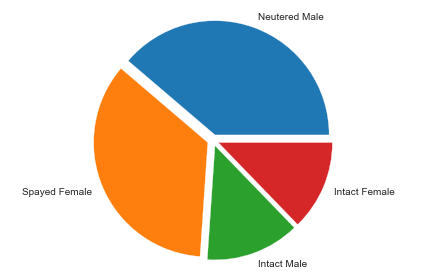

In [117]:
sex_upon_outcome = aso['sex_upon_outcome'].value_counts().head(4)
explode = (0.05, 0.05, 0.05, 0.05)  # explode 1st slice
# Plot
plt.pie(sex_upon_outcome.values, explode=explode, labels=sex_upon_intake.index)
plt.axis('equal')
plt.tight_layout()
plt.show()

Посмотрим строки, в которых есть Unknown-значения.

In [127]:
aso[aso['sex_upon_outcome']=='Unknown']

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown
6,1 year,A693700,Other,Squirrel Mix,Tan,2013-12-13T00:00:00,2014-12-13T12:20:00,2014-12-13T12:20:00,NaN,Suffering,Euthanasia,Unknown
20,8 months,A673952,Cat,Domestic Shorthair Mix,Brown Tabby/White,2013-07-05T00:00:00,2014-03-06T14:29:00,2014-03-06T14:29:00,NaN,SCRP,Transfer,Unknown
30,2 weeks,A681039,Cat,Domestic Shorthair Mix,Black,2014-05-27T00:00:00,2014-06-11T17:11:00,2014-06-11T17:11:00,NaN,Partner,Transfer,Unknown
40,1 year,A683068,Other,Bat,Black/Brown,2013-07-06T00:00:00,2014-07-07T08:40:00,2014-07-07T08:40:00,NaN,Rabies Risk,Euthanasia,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
78200,3 years,A765877,Cat,Domestic Shorthair Mix,White/Black,2015-01-29T00:00:00,2018-01-31T18:07:00,2018-01-31T18:07:00,NaN,Snr,Transfer,Unknown
78206,2 years,A765221,Bird,Pheasant Mix,Gold/Brown,2016-01-15T00:00:00,2018-01-18T15:49:00,2018-01-18T15:49:00,NaN,Partner,Transfer,Unknown
78219,2 years,A766079,Other,Raccoon Mix,Black/Gray,2016-02-01T00:00:00,2018-02-01T13:46:00,2018-02-01T13:46:00,NaN,Medical,Euthanasia,Unknown
78220,2 years,A766080,Other,Raccoon Mix,Black/Gray,2016-02-01T00:00:00,2018-02-01T13:46:00,2018-02-01T13:46:00,NaN,Medical,Euthanasia,Unknown


In [ ]:
Посмотрим строки, в которых есть NaN-значения.

In [143]:
aso[aso['sex_upon_outcome'].isnull()]

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
16300,7 years,A667395,Dog,Dachshund,Brown Merle,2006-11-17T00:00:00,2013-11-27T16:11:00,2013-11-27T16:11:00,Diego,NaN,Return to Owner,NaN
68246,NaN,A737705,Dog,Labrador Retriever Mix,Black/White,2013-11-02T00:00:00,2016-11-19T16:35:00,2016-11-19T16:35:00,*Heddy,NaN,NaN,NaN


In [30]:
df = aso.copy()

In [32]:
df[df.duplicated(keep=False)]

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
1240,2 years,A686827,Cat,Domestic Shorthair Mix,Calico,2012-02-27T00:00:00,2014-08-28T09:00:00,2014-08-28T09:00:00,NaN,SCRP,Transfer,Spayed Female
1241,2 years,A686827,Cat,Domestic Shorthair Mix,Calico,2012-02-27T00:00:00,2014-08-28T09:00:00,2014-08-28T09:00:00,NaN,SCRP,Transfer,Spayed Female
5827,4 months,A683782,Cat,Domestic Shorthair Mix,Brown Tabby,2014-02-15T00:00:00,2014-07-16T09:00:00,2014-07-16T09:00:00,NaN,SCRP,Transfer,Neutered Male
5828,4 months,A683782,Cat,Domestic Shorthair Mix,Brown Tabby,2014-02-15T00:00:00,2014-07-16T09:00:00,2014-07-16T09:00:00,NaN,SCRP,Transfer,Neutered Male
12145,1 year,A682781,Cat,Domestic Shorthair Mix,White/Black,2013-01-02T00:00:00,2014-07-03T09:00:00,2014-07-03T09:00:00,NaN,SCRP,Transfer,Neutered Male
12146,1 year,A682781,Cat,Domestic Shorthair Mix,White/Black,2013-01-02T00:00:00,2014-07-03T09:00:00,2014-07-03T09:00:00,NaN,SCRP,Transfer,Neutered Male
17319,3 months,A660948,Cat,Domestic Shorthair Mix,Brown Tabby/White,2013-07-08T00:00:00,2013-11-03T18:16:00,2013-11-03T18:16:00,*Roy,NaN,Adoption,Neutered Male
17320,3 months,A660948,Cat,Domestic Shorthair Mix,Brown Tabby/White,2013-07-08T00:00:00,2013-11-03T18:16:00,2013-11-03T18:16:00,*Roy,NaN,Adoption,Neutered Male
23439,10 months,A695798,Cat,Domestic Shorthair Mix,Orange,2014-02-23T00:00:00,2015-01-23T12:34:00,2015-01-23T12:34:00,Jim,Suffering,Euthanasia,Neutered Male
23440,10 months,A695798,Cat,Domestic Shorthair Mix,Orange,2014-02-23T00:00:00,2015-01-23T12:34:00,2015-01-23T12:34:00,Jim,Suffering,Euthanasia,Neutered Male


In [34]:
len(df[df.duplicated(keep=False)])/2

10.0

Действительно, как показал нам профайлер, у нас десять совпадений.

In [35]:
df['outcome_type'].unique()

array(['Transfer', 'Adoption', 'Euthanasia', 'Return to Owner', 'Died',
       'Disposal', 'Relocate', 'Missing', nan, 'Rto-Adopt'], dtype=object)

In [39]:
df[df['outcome_type']=='Transfer'].sample(5)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
45763,1 month,A749910,Dog,German Shepherd Mix,Tan/Black,2017-03-30T00:00:00,2017-05-24T09:54:00,2017-05-24T09:54:00,*Barney,Partner,Transfer,Intact Male
55113,1 year,A702358,Cat,Domestic Shorthair Mix,Tortie,2014-05-12T00:00:00,2015-05-13T09:00:00,2015-05-13T09:00:00,NaN,SCRP,Transfer,Intact Female
54455,4 weeks,A758432,Cat,Domestic Shorthair Mix,Gray Tabby,2017-08-16T00:00:00,2017-09-16T00:00:00,2017-09-16T00:00:00,NaN,Partner,Transfer,Intact Male
41529,8 months,A762886,Dog,German Shepherd Mix,Black/White,2017-03-30T00:00:00,2017-12-06T15:27:00,2017-12-06T15:27:00,Mickey,Partner,Transfer,Neutered Male
69668,2 months,A735200,Cat,Domestic Shorthair Mix,White/Blue,2016-07-20T00:00:00,2016-09-23T17:07:00,2016-09-23T17:07:00,NaN,Partner,Transfer,Neutered Male


In [40]:
df[df['outcome_type']=='Adoption'].sample(5)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
68757,2 months,A700605,Dog,Black Mouth Cur Mix,Brown/White,2015-01-29T00:00:00,2015-04-25T16:54:00,2015-04-25T16:54:00,Boudreaux,Foster,Adoption,Neutered Male
41567,2 months,A758722,Cat,Domestic Shorthair Mix,Black,2017-07-20T00:00:00,2017-10-07T17:59:00,2017-10-07T17:59:00,*Jessie,NaN,Adoption,Spayed Female
28133,1 year,A724860,Dog,Australian Cattle Dog/Labrador Retriever,Black/White,2015-02-22T00:00:00,2016-05-25T19:19:00,2016-05-25T19:19:00,Moon,NaN,Adoption,Neutered Male
74726,3 months,A741859,Cat,Domestic Shorthair Mix,Calico,2016-10-10T00:00:00,2017-01-15T18:46:00,2017-01-15T18:46:00,NaN,NaN,Adoption,Spayed Female
3886,1 year,A680301,Dog,Australian Cattle Dog Mix,Red,2012-12-01T00:00:00,2014-07-12T16:07:00,2014-07-12T16:07:00,Cleo,NaN,Adoption,Spayed Female


In [41]:
Transfer=df[df['outcome_type']=='Transfer']

In [42]:
Adoption=df[df['outcome_type']=='Adoption']

In [43]:
Transfer.describe()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
count,23497,23499,23499,23499,23499,23499,23499,23499,11106,23499,23499,23499
unique,44,23337,5,982,355,3993,14287,14287,5779,4,1,5
top,1 year,A688299,Cat,Domestic Shorthair Mix,Black,2015-09-01T00:00:00,2016-04-18T00:00:00,2016-04-18T00:00:00,Bella,Partner,Transfer,Intact Female
freq,3994,3,13323,10908,2446,57,39,39,43,19660,23499,6110


In [44]:
Adoption.describe()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
count,33112,33112,33112,33112,33112,33112,33112,33112,27554,5926,33112,33112
unique,36,30329,5,1498,388,4280,31291,31291,9478,3,1,5
top,2 months,A732618,Dog,Domestic Shorthair Mix,Black/White,2014-04-21T00:00:00,2017-08-19T00:00:00,2017-08-19T00:00:00,Bella,Foster,Adoption,Neutered Male
freq,7405,6,20052,9901,3675,59,7,7,161,5558,33112,15906


Здесь работаем с копией датасета:

In [282]:
df.shape

(78182, 14)

In [300]:
df[df['sex_upon_outcome'].isnull()] # в процессе работы с атрибутами по удалению
# количество NaN-значений уменьшилось.

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,date_of_birth_unix,datetime_unix,monthyear_unix,diff_date_unix,diff_date_timedelta
16300,7 years,A667395,Dog,Dachshund,Brown Merle,2006-11-17T00:00:00,2013-11-27T16:11:00,2013-11-27T16:11:00,Diego,NaN,Return to Owner,NaN,1.163711e+09,1.385558e+09,1.385558e+09,221847060.0,"7.0 years, 1.0 week"


In [ ]:
Удалим неинформативные строчки.

In [301]:
df=df.loc[~df['sex_upon_outcome'].isnull()]

In [302]:
df.shape

(78181, 17)

In [342]:
df

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome,date_of_birth_unix,datetime_unix,monthyear_unix,diff_date_unix,diff_date_timedelta,name_new,color_cnt
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male,1.404680e+09,1.406034e+09,1.406034e+09,1353840.0,"2.0 weeks, 1.0 day",Unknown,1
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female,1.352149e+09,1.383814e+09,1.383814e+09,31664820.0,"1.0 year, 1.0 day",Lucy,2
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,Unknown,Adoption,Neutered Male,1.364677e+09,1.401794e+09,1.401794e+09,37117200.0,"1.0 year, 2.0 months",Marked_name,2
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male,1.117660e+09,1.402837e+09,1.402837e+09,285177000.0,"9.0 years, 1.0 week",Monday,1
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown,1.389042e+09,1.404731e+09,1.404731e+09,15689040.0,"6.0 months, 5.0 days",Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78250,1 month,A764895,Dog,Golden Retriever/Labrador Retriever,Brown/White,2017-12-04T00:00:00,2018-02-01T18:40:00,2018-02-01T18:40:00,NaN,Foster,Adoption,Neutered Male,1.512335e+09,1.517500e+09,1.517500e+09,5164800.0,"2.0 months, 1.0 day",Unknown,2
78251,1 month,A764894,Dog,Golden Retriever/Labrador Retriever,Brown/White,2017-12-04T00:00:00,2018-02-01T18:26:00,2018-02-01T18:26:00,NaN,Foster,Adoption,Spayed Female,1.512335e+09,1.517499e+09,1.517499e+09,5163960.0,"2.0 months, 1.0 day",Unknown,2
78252,3 years,A764468,Dog,Mastiff Mix,Blue/White,2014-12-30T00:00:00,2018-02-01T18:06:00,2018-02-01T18:06:00,Max,Unknown,Adoption,Neutered Male,1.419887e+09,1.517498e+09,1.517498e+09,97610760.0,"3.0 years, 1.0 month",Max,2
78254,2 months,A765858,Dog,Standard Schnauzer,Red,2017-11-13T00:00:00,2018-02-01T18:32:00,2018-02-01T18:32:00,NaN,Unknown,Adoption,Spayed Female,1.510520e+09,1.517499e+09,1.517499e+09,6978720.0,"2.0 months, 3.0 weeks",Unknown,1


In [324]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78181 entries, 0 to 78255
Data columns (total 19 columns):
age_upon_outcome       78181 non-null object
animal_id              78181 non-null object
animal_type            78181 non-null object
breed                  78181 non-null object
color                  78181 non-null object
date_of_birth          78181 non-null object
datetime               78181 non-null object
monthyear              78181 non-null object
name                   54306 non-null object
outcome_subtype        78181 non-null object
outcome_type           78181 non-null object
sex_upon_outcome       78181 non-null object
date_of_birth_unix     78181 non-null float64
datetime_unix          78181 non-null float64
monthyear_unix         78181 non-null float64
diff_date_unix         78181 non-null float64
diff_date_timedelta    78181 non-null object
name_new               78181 non-null object
color_cnt              78181 non-null int64
dtypes: float64(4), int64(1), obj

Мы из атрибута 'name' создали атрибут 'name_new' и можем спокойно удалить колонку 'name' с NaN-значениями.

In [343]:
df.columns

Index(['age_upon_outcome', 'animal_id', 'animal_type', 'breed', 'color',
       'date_of_birth', 'datetime', 'monthyear', 'name', 'outcome_subtype',
       'outcome_type', 'sex_upon_outcome', 'date_of_birth_unix',
       'datetime_unix', 'monthyear_unix', 'diff_date_unix',
       'diff_date_timedelta', 'name_new', 'color_cnt'],
      dtype='object')

Провели большую работу, почти подготовили таблицу. Сделаем ещё раз копию с датасета df и посмотрим, что ещё можно сделать. 

'age_upon_outcome', 'animal_id', 'animal_type', 'breed', 'color',
       'date_of_birth', 'datetime', 'monthyear', 'name', 'outcome_subtype',
       'outcome_type', 'sex_upon_outcome', 'date_of_birth_unix',
       'datetime_unix', 'monthyear_unix', 'diff_date_unix',
       'diff_date_timedelta', 'name_new', 'color_cnt'

In [346]:
data = df.copy()

Удалим столбцы, которые не влияют или слабо влияют на классификацию.

In [347]:
names = ['date_of_birth', 'datetime','monthyear','name', 'monthyear_unix']
data.drop(names, axis=1, inplace = True)

In [348]:
data.shape

(78181, 14)

In [349]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78181 entries, 0 to 78255
Data columns (total 14 columns):
age_upon_outcome       78181 non-null object
animal_id              78181 non-null object
animal_type            78181 non-null object
breed                  78181 non-null object
color                  78181 non-null object
outcome_subtype        78181 non-null object
outcome_type           78181 non-null object
sex_upon_outcome       78181 non-null object
date_of_birth_unix     78181 non-null float64
datetime_unix          78181 non-null float64
diff_date_unix         78181 non-null float64
diff_date_timedelta    78181 non-null object
name_new               78181 non-null object
color_cnt              78181 non-null int64
dtypes: float64(3), int64(1), object(10)
memory usage: 8.9+ MB


### Создадим новые атрибуты с помощью OneHotEncoder() и LabelEncoder().

### OneHotEncoder()

##### 'animal_type'

In [350]:
# Данный метод лучше использовать, когда мало значений.
data['animal_type'].unique()

array(['Cat', 'Dog', 'Other', 'Bird', 'Livestock'], dtype=object)

In [352]:
# Преобразуем атрибут 'animal_type' в one-hot encoding вектор.
one_hot = pd.get_dummies(df['animal_type'])
# Удаляем колонку 'animal_type'.
data = df.drop(['animal_type'],axis = 1)
# Добавляем one-hot encoding вектор к исходному датасету.
data = data.join(one_hot)
data.head()

,age_upon_outcome,animal_id,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,...,monthyear_unix,diff_date_unix,diff_date_timedelta,name_new,color_cnt,Bird,Cat,Dog,Livestock,Other
0,2 weeks,A684346,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,...,1.406034e+09,1353840.0,"2.0 weeks, 1.0 day",Unknown,1,0,1,0,0,0
1,1 year,A666430,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,...,1.383814e+09,31664820.0,"1.0 year, 1.0 day",Lucy,2,0,0,1,0,0
2,1 year,A675708,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,Unknown,Adoption,...,1.401794e+09,37117200.0,"1.0 year, 2.0 months",Marked_name,2,0,0,1,0,0
3,9 years,A680386,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,...,1.402837e+09,285177000.0,"9.0 years, 1.0 week",Monday,1,0,0,1,0,0
4,5 months,A683115,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,...,1.404731e+09,15689040.0,"6.0 months, 5.0 days",Unknown,1,0,0,0,0,1


#### 'sex_upon_outcome'

In [353]:
# Данный метод лучше использовать, когда мало значений.
data['sex_upon_outcome'].unique()

array(['Intact Male', 'Spayed Female', 'Neutered Male', 'Unknown',
       'Intact Female'], dtype=object)

In [354]:
# Преобразуем атрибут 'animal_type' в one-hot encoding вектор.
one_hot = pd.get_dummies(df['sex_upon_outcome'])
# Удаляем колонку 'animal_type'.
data = data.drop(['sex_upon_outcome'],axis = 1)
# Добавляем one-hot encoding вектор к исходному датасету.
data = data.join(one_hot)
data.head()

,age_upon_outcome,animal_id,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,...,Bird,Cat,Dog,Livestock,Other,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown
0,2 weeks,A684346,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,...,0,1,0,0,0,0,1,0,0,0
1,1 year,A666430,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,...,0,0,1,0,0,0,0,0,1,0
2,1 year,A675708,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,Unknown,Adoption,...,0,0,1,0,0,0,0,1,0,0
3,9 years,A680386,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,...,0,0,1,0,0,0,0,1,0,0
4,5 months,A683115,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,...,0,0,0,0,1,0,0,0,0,1


In [355]:
names = ['date_of_birth', 'datetime','monthyear','name', 'monthyear_unix']
data.drop(names, axis=1, inplace = True)

In [356]:
data.columns

Index(['age_upon_outcome', 'animal_id', 'breed', 'color', 'outcome_subtype',
       'outcome_type', 'date_of_birth_unix', 'datetime_unix', 'diff_date_unix',
       'diff_date_timedelta', 'name_new', 'color_cnt', 'Bird', 'Cat', 'Dog',
       'Livestock', 'Other', 'Intact Female', 'Intact Male', 'Neutered Male',
       'Spayed Female', 'Unknown'],
      dtype='object')

### LabelEncoder()

In [357]:
# Когда значений у атрибутов много, используем LabelEncoder()
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

data['age_upon_outcome_le'] = le.fit_transform(df['age_upon_outcome'])
data['animal_id_le'] = le.fit_transform(df['animal_id'])
data['breed_le'] = le.fit_transform(df['breed'])
data['color_le'] = le.fit_transform(df['color'])
data['outcome_subtype_le'] = le.fit_transform(df['outcome_subtype'])
data['diff_date_timedelta_le'] = le.fit_transform(df['diff_date_timedelta'])
data['name_new_le'] = le.fit_transform(df['name_new'])

data.drop(['age_upon_outcome', 'animal_id', 'breed', 'color', 'outcome_subtype', 'diff_date_timedelta', 'name_new'], axis = 1, inplace = True)
data.head()

,outcome_type,date_of_birth_unix,datetime_unix,diff_date_unix,color_cnt,Bird,Cat,Dog,Livestock,Other,...,Neutered Male,Spayed Female,Unknown,age_upon_outcome_le,animal_id_le,breed_le,color_le,outcome_subtype_le,diff_date_timedelta_le,name_new_le
0,Transfer,1.404680e+09,1.406034e+09,1353840.0,1,0,1,0,0,0,...,0,0,0,20,17316,937,321,12,524,8321
1,Transfer,1.352149e+09,1.383814e+09,31664820.0,2,0,0,1,0,0,...,0,1,0,5,5653,255,474,12,62,4697
2,Adoption,1.364677e+09,1.401794e+09,37117200.0,2,0,0,1,0,0,...,1,0,0,5,11301,1612,119,19,78,4932
3,Transfer,1.117660e+09,1.402837e+09,285177000.0,1,0,0,1,0,0,...,1,0,0,45,14545,1467,463,12,1091,5322
4,Euthanasia,1.389042e+09,1.404731e+09,15689040.0,1,0,0,0,0,1,...,0,0,1,34,16439,253,122,14,916,8321


### Закодируем целевое значение, дропать не будем изначальный столбец.

In [358]:
# Данный метод лучше использовать, когда мало значений.
data['outcome_type'].unique()

array(['Transfer', 'Adoption', 'Euthanasia', 'Return to Owner', 'Died',
       'Disposal', 'Relocate', 'Missing', 'Rto-Adopt'], dtype=object)

In [359]:
data['outcome_type'].value_counts()

Adoption           33109
Transfer           23496
Return to Owner    14302
Euthanasia          6076
Died                 680
Disposal             307
Rto-Adopt            149
Missing               46
Relocate              16
Name: outcome_type, dtype: int64

In [360]:
# Преобразуем атрибут 'animal_type' в one-hot encoding вектор.
one_hot = pd.get_dummies(df['outcome_type'])
  # Удаляем колонку 'animal_type'.
  #data = data.drop(['outcome_type'],axis = 1)
# Добавляем one-hot encoding вектор к исходному датасету.
data = data.join(one_hot)
data.head()

,outcome_type,date_of_birth_unix,datetime_unix,diff_date_unix,color_cnt,Bird,Cat,Dog,Livestock,Other,...,name_new_le,Adoption,Died,Disposal,Euthanasia,Missing,Relocate,Return to Owner,Rto-Adopt,Transfer
0,Transfer,1.404680e+09,1.406034e+09,1353840.0,1,0,1,0,0,0,...,8321,0,0,0,0,0,0,0,0,1
1,Transfer,1.352149e+09,1.383814e+09,31664820.0,2,0,0,1,0,0,...,4697,0,0,0,0,0,0,0,0,1
2,Adoption,1.364677e+09,1.401794e+09,37117200.0,2,0,0,1,0,0,...,4932,1,0,0,0,0,0,0,0,0
3,Transfer,1.117660e+09,1.402837e+09,285177000.0,1,0,0,1,0,0,...,5322,0,0,0,0,0,0,0,0,1
4,Euthanasia,1.389042e+09,1.404731e+09,15689040.0,1,0,0,0,0,1,...,8321,0,0,0,1,0,0,0,0,0


In [ ]:
#data['outcome_type_le'] = le.fit_transform(df['outcome_type'])
#Или с помощью этого метода

# Модель деревья решений (Random Forest) для классификационной задачи

Задача обучить модель таким образом, чтобы  по определенным признакам была возможность максимально уверенно предсказать метки 'Adoption' и 'Transfer' (столбец “outcome_type”)

In [363]:
y = data[['Adoption', 'Transfer']]
X = data.iloc[:,1:22]

In [365]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

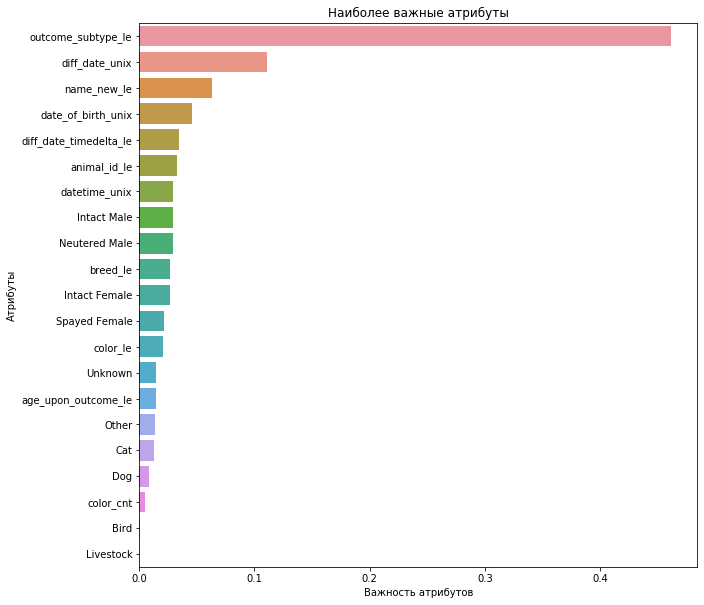

In [366]:
from sklearn.ensemble import RandomForestClassifier

# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators = 100)

# обучаем модель
model.fit(X_train,y_train)

headers = list(X_train.columns.values)

# вклад каждого из регрессоров в целевое значение, 
feature_imp = pd.Series(model.feature_importances_, index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
#plt.legend()
plt.show()

In [367]:
from sklearn.metrics import classification_report


model_pred = model.predict(X_test)
print(classification_report(y_test, model_pred))
model.score(X_test, y_test)

              precision    recall  f1-score   support

           0       0.89      0.90      0.89     10010
           1       1.00      1.00      1.00      6980

   micro avg       0.93      0.94      0.94     16990
   macro avg       0.94      0.95      0.94     16990
weighted avg       0.93      0.94      0.94     16990
 samples avg       0.68      0.68      0.68     16990



0.9056917501598806

Мы даже не нормализовывали данные, результат предсказания по атрибуту 'Adoption' составляет 89%, по атрибуту 'Transfer' составляет 100%.  
Общий показатель 91%.  
**Приятно сознавать, что созданные атрибуты имеют важность.** Например, если сравнить 'diff_date_unix', 'diff_date_timedelta_le' и 'age_upon_outcome_le'.

## Проведём нормализацию и повторим на нормализованных данных.

Но, как правило, случайный лес лучше работает на ненормализованных данных. Поэтому приведём только решение на нахождение наиболее важных атрибутов.

In [392]:
data_norm = data.copy() 

In [393]:
data_norm

,outcome_type,date_of_birth_unix,datetime_unix,diff_date_unix,color_cnt,Bird,Cat,Dog,Livestock,Other,...,name_new_le,Adoption,Died,Disposal,Euthanasia,Missing,Relocate,Return to Owner,Rto-Adopt,Transfer
0,Transfer,1.404680e+09,1.406034e+09,1353840.0,1,0,1,0,0,0,...,8321,0,0,0,0,0,0,0,0,1
1,Transfer,1.352149e+09,1.383814e+09,31664820.0,2,0,0,1,0,0,...,4697,0,0,0,0,0,0,0,0,1
2,Adoption,1.364677e+09,1.401794e+09,37117200.0,2,0,0,1,0,0,...,4932,1,0,0,0,0,0,0,0,0
3,Transfer,1.117660e+09,1.402837e+09,285177000.0,1,0,0,1,0,0,...,5322,0,0,0,0,0,0,0,0,1
4,Euthanasia,1.389042e+09,1.404731e+09,15689040.0,1,0,0,0,0,1,...,8321,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78250,Adoption,1.512335e+09,1.517500e+09,5164800.0,2,0,0,1,0,0,...,8321,1,0,0,0,0,0,0,0,0
78251,Adoption,1.512335e+09,1.517499e+09,5163960.0,2,0,0,1,0,0,...,8321,1,0,0,0,0,0,0,0,0
78252,Adoption,1.419887e+09,1.517498e+09,97610760.0,2,0,0,1,0,0,...,5002,1,0,0,0,0,0,0,0,0
78254,Adoption,1.510520e+09,1.517499e+09,6978720.0,1,0,0,1,0,0,...,8321,1,0,0,0,0,0,0,0,0


In [394]:
data_norm = data_norm.drop(['outcome_type'], axis = 1)
data_norm

,date_of_birth_unix,datetime_unix,diff_date_unix,color_cnt,Bird,Cat,Dog,Livestock,Other,Intact Female,...,name_new_le,Adoption,Died,Disposal,Euthanasia,Missing,Relocate,Return to Owner,Rto-Adopt,Transfer
0,1.404680e+09,1.406034e+09,1353840.0,1,0,1,0,0,0,0,...,8321,0,0,0,0,0,0,0,0,1
1,1.352149e+09,1.383814e+09,31664820.0,2,0,0,1,0,0,0,...,4697,0,0,0,0,0,0,0,0,1
2,1.364677e+09,1.401794e+09,37117200.0,2,0,0,1,0,0,0,...,4932,1,0,0,0,0,0,0,0,0
3,1.117660e+09,1.402837e+09,285177000.0,1,0,0,1,0,0,0,...,5322,0,0,0,0,0,0,0,0,1
4,1.389042e+09,1.404731e+09,15689040.0,1,0,0,0,0,1,0,...,8321,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78250,1.512335e+09,1.517500e+09,5164800.0,2,0,0,1,0,0,0,...,8321,1,0,0,0,0,0,0,0,0
78251,1.512335e+09,1.517499e+09,5163960.0,2,0,0,1,0,0,0,...,8321,1,0,0,0,0,0,0,0,0
78252,1.419887e+09,1.517498e+09,97610760.0,2,0,0,1,0,0,0,...,5002,1,0,0,0,0,0,0,0,0
78254,1.510520e+09,1.517499e+09,6978720.0,1,0,0,1,0,0,0,...,8321,1,0,0,0,0,0,0,0,0


Выделим колонки в отдельный список

In [395]:
headers = list(data_norm.columns.values)

**Нормализуем** параметры

In [396]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))

np_scaled = min_max_scaler.fit_transform(data_norm)
data_norm = pd.DataFrame(np_scaled)
data_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.733572,-0.628533,-0.970168,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,0.900640,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
1,0.605720,-0.953175,-0.894392,0.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,...,0.072864,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2,0.636211,-0.690478,-0.880761,0.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,...,0.126542,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,0.035012,-0.675251,-0.260624,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,...,0.215624,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
4,0.695510,-0.647573,-0.934331,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,...,0.900640,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0


При нормализации стираются названия колонок, поэтому необходимо **восстановить** их:

In [397]:
data_norm.columns = headers
data_norm.head()

,date_of_birth_unix,datetime_unix,diff_date_unix,color_cnt,Bird,Cat,Dog,Livestock,Other,Intact Female,...,name_new_le,Adoption,Died,Disposal,Euthanasia,Missing,Relocate,Return to Owner,Rto-Adopt,Transfer
0,0.733572,-0.628533,-0.970168,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,0.900640,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
1,0.605720,-0.953175,-0.894392,0.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,...,0.072864,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2,0.636211,-0.690478,-0.880761,0.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,...,0.126542,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,0.035012,-0.675251,-0.260624,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,...,0.215624,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
4,0.695510,-0.647573,-0.934331,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,...,0.900640,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [398]:
y_n = data_norm[['Adoption', 'Transfer']]
X_n = data_norm.iloc[:,:21]

In [399]:
data_norm.iloc[:,:21]

,date_of_birth_unix,datetime_unix,diff_date_unix,color_cnt,Bird,Cat,Dog,Livestock,Other,Intact Female,...,Neutered Male,Spayed Female,Unknown,age_upon_outcome_le,animal_id_le,breed_le,color_le,outcome_subtype_le,diff_date_timedelta_le,name_new_le
0,0.733572,-0.628533,-0.970168,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-0.111111,-0.511082,-0.118118,0.225191,0.263158,-0.063450,0.900640
1,0.605720,-0.953175,-0.894392,0.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,-1.0,-0.777778,-0.840387,-0.760000,0.809160,0.263158,-0.889187,0.072864
2,0.636211,-0.690478,-0.880761,0.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,-0.777778,-0.680916,0.517176,-0.545802,1.000000,-0.860590,0.126542
3,0.035012,-0.675251,-0.260624,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,1.000000,-0.589322,0.380706,0.767176,0.263158,0.949955,0.215624
4,0.695510,-0.647573,-0.934331,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,...,-1.0,-1.0,1.0,0.511111,-0.535844,-0.761882,-0.534351,0.473684,0.637176,0.900640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78176,0.995584,0.999996,-0.960641,0.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,-0.911111,0.987040,0.040941,-0.305344,-0.368421,-0.127793,0.900640
78177,0.995584,0.999984,-0.960643,0.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,-1.0,-0.911111,0.987012,0.040941,-0.305344,-0.368421,-0.127793,0.900640
78178,0.770581,0.999967,-0.729530,0.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,0.244444,0.980772,0.329882,-0.545802,1.000000,0.206434,0.142531
78179,0.991168,0.999989,-0.956106,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,-1.0,-0.155556,0.999322,0.872941,0.293893,1.000000,-0.093834,0.900640


In [401]:
from sklearn.model_selection import train_test_split
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, y_n, test_size=0.3)

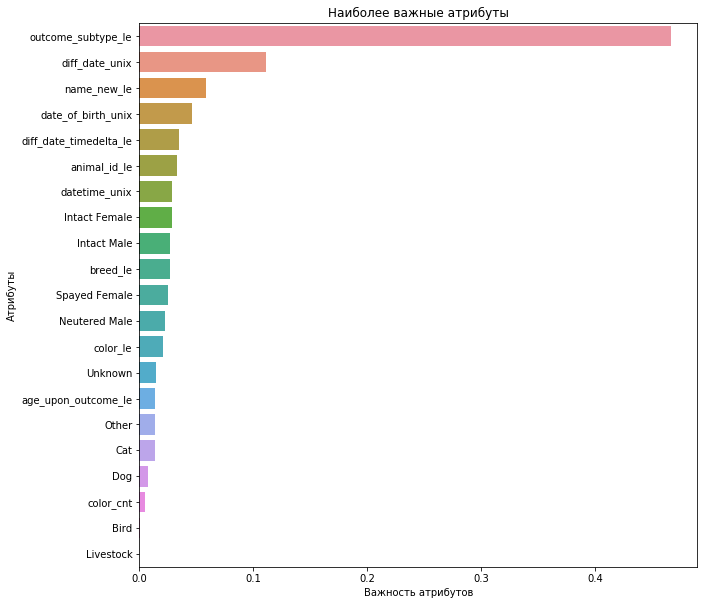

In [402]:
from sklearn.ensemble import RandomForestClassifier

# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators = 100)

# обучаем модель
model.fit(X_train_n,y_train_n)

headers = list(X_train_n.columns.values)

# вклад каждого из регрессоров в целевое значение, 
feature_imp = pd.Series(model.feature_importances_, index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
#plt.legend()
plt.show()

In [405]:
X_test_n

,date_of_birth_unix,datetime_unix,diff_date_unix,color_cnt,Bird,Cat,Dog,Livestock,Other,Intact Female,...,Neutered Male,Spayed Female,Unknown,age_upon_outcome_le,animal_id_le,breed_le,color_le,outcome_subtype_le,diff_date_timedelta_le,name_new_le
63468,0.857218,0.568196,-0.892401,0.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,-0.777778,0.610752,-0.118118,-0.110687,0.263158,-0.883825,0.126542
52523,0.893176,0.319586,-0.971876,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-0.866667,0.407319,-0.118118,0.606870,0.263158,-0.908847,0.900640
28461,0.331511,0.174416,-0.419791,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,-1.0,0.822222,0.244600,0.518118,-0.530534,0.263158,0.753351,0.527867
12982,0.663127,-0.974246,-0.956964,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,-1.0,-0.155556,-0.857470,-0.502118,0.534351,1.000000,-0.113494,0.900640
15316,-0.099779,-0.611245,-0.111219,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,-1.0,-0.688889,-0.895700,-0.118118,-0.263359,-0.368421,-0.780161,0.126542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,0.696772,-0.829061,-0.966681,0.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,...,-1.0,-1.0,1.0,0.377778,-0.733744,0.657412,-0.389313,1.000000,-0.955317,0.900640
39122,0.796867,0.040914,-0.920633,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,0.866667,-0.045148,-0.118118,0.225191,0.263158,0.817694,0.126542
34999,0.821680,-0.116021,-0.972974,0.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-0.200000,0.003586,-0.118118,0.774809,0.263158,-0.136729,0.900640
16460,0.712964,-0.695823,-0.960514,0.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,...,-1.0,-1.0,-1.0,-0.911111,-0.612305,-0.118118,-0.408397,1.000000,-0.127793,-0.893330


In [406]:
y_test_n

,Adoption,Transfer
63468,-1.0,1.0
52523,-1.0,1.0
28461,-1.0,1.0
12982,1.0,-1.0
15316,1.0,-1.0
...,...,...
287,-1.0,-1.0
39122,-1.0,1.0
34999,-1.0,1.0
16460,1.0,-1.0


In [407]:
model_pred_n

array([[-1.,  1.],
       [-1.,  1.],
       [-1.,  1.],
       ...,
       [-1.,  1.],
       [ 1., -1.],
       [ 1., -1.]])

In [ ]:
#from sklearn.metrics import classification_report
model_pred_n = model.predict(X_test_n)
#print(classification_report(y_test_n, model_pred_n))
#model.score(X_test_n, y_test_n)